In [2]:
import json
import os, shutil
from ovejero import model_trainer, hierarchical_inference
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib

def NOTIMPLEMENTED():
    raise NotImplementedError('Must specify config/save path')

2023-09-17 23:06:53.972369: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-17 23:06:54.657305: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/parlange/anaconda3/envs/bnn/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


# Hierarchical Inference on a Test Set

__Author:__ Sebastian Wagner-Carena

__Last Run:__ 08/15/2020

__Goals:__ Learn how to run hierarchical inference on a test set using a trained BNN

__Before running this notebook:__ Train a model and generate a test set on which you want to run hiearchical inference.

To run hierarchical inference first we need to specify the path to the config files we'll use. There are three required configs for hierarchical inference:

1. The ovejero bnn config used for training/validation/testing

2. The ovejero distribution config that specifies the hyperparameters we'll run hierarchical inference over. For an example see the config in configs/baobab_configs/cent_narrow_cfg_prior.py.

3. The baobab config used to geneate the training set.

You can also optionally specify the baobab config used to generate the test set. This will be used to plot the true values of the hyperparameters you're trying to infer.

In [4]:
# These are also optional, but these are the names of the hyperparameters and parameters of the lens sample.
# They will only be used in plotting.
hyperparam_plot_names = [r'$\mu_{\log(\gamma_\mathrm{ext})}$',r'$\sigma_{\log(\gamma_\mathrm{ext})}$',
                         r'$\mu_x$',r'$\sigma_x$',r'$\mu_y$',r'$\sigma_y$',
                         r'$\mu_{e1}$',r'$\sigma_{e1}$',
                         r'$\mu_{e2}$',r'$\sigma_{e2}$',
                         r'$\mu_{\log (\gamma_\mathrm{lens})}$',r'$\sigma_{\log (\gamma_\mathrm{lens})}$',
                         r'$\mu_{\log (\theta_E)}$',r'$\sigma_{\log (\theta_E)}$']
param_plot_names = [r'$\gamma_\mathrm{ext}$', r'$\psi_\mathrm{ext}$',r'$x_\mathrm{lens}$',
            r'$y_\mathrm{lens}$',r'$e_1$',r'$e_2$',r'$\gamma_\mathrm{lens}$',r'$\theta_E$']

# The config path used to train the BNN
bnn_config_path = '/home/parlange/ovejero/test/test_data/diag.json'
bnn_cfg = model_trainer.load_config(bnn_config_path)

def recursive_str_checker(cfg_dict):
    for key in cfg_dict:
        if isinstance(cfg_dict[key],str):
            cfg_dict[key] = cfg_dict[key].replace('/home/swagnercarena/ovejero/', '/home/parlange/ovejero/')
        if isinstance(cfg_dict[key],dict):
            recursive_str_checker(cfg_dict[key])
recursive_str_checker(bnn_cfg)

# The baobab config used to generate the training set.
interim_baobab_omega_path = '/home/parlange/ovejero/test/test_data/test_baobab_cfg.py'

# The ovejero distribution config specifying the hyperparameters you want to fit.
target_ovejero_omega_path = '/home/parlange/ovejero/configs/baobab_configs/test_ovejero_cfg_prior.py'

# Optional, but you can also specify the baobab config used to generate the test set.
target_baobab_omega_path = '/home/parlange/ovejero/test/test_data/test_baobab_cfg_target.py'

# The path to the test dataset
test_dataset_path = '/home/parlange/ovejero/test/test_data/'

# The path to which the tf record will be saved
test_dataset_tf_record_path = '/home/parlange/ovejero/test/test_data/tfrecord/'

# The number of walkers to use in the hierarchical inference. This should be AT LEAST double the number of
# hyperparameters that are being inferred.
n_walkers = 50

# If you've already generated the samples you can set this to True. If you do, the weights won't be
# loaded, avoiding memory errors.
lite_class = False

# The HierarchicalClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the test dataset, and providing outputs correctly marginalized over the BNN uncertainties.
# To initialize it we need to pass in our config files
hier_infer = hierarchical_inference.HierarchicalClass(bnn_cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                      test_dataset_path,test_dataset_tf_record_path,
                                                      target_baobab_omega_path=target_baobab_omega_path,
                                                      lite_class=lite_class)

2023-09-17 23:07:18.420987: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


Is model built: True
Loaded weights /home/parlange/ovejero/test/test_data/test_model.h5
TFRecord found at /home/parlange/ovejero/test/test_data/tf_record_test_val
Generating new TFRecord at /home/parlange/ovejero/test/test_data/tfrecord/


100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1364.53it/s]


After we've initialized our class, we need to generate bnn samples for the lenses in our test set.

In [5]:
# A path where the BNN samples will be saved
#save_path_samples = '/home/parlange/ovejero/hierarchical_results_upload/cn_nn1_hr_samps/'
save_path_samples = '/home/parlange/ovejero/test/test_data/bnnsamples/'

# The number of BNN samples to draw per lens
num_samples = 1000

# This command will generate the samples on the test set
hier_infer.gen_samples(num_samples, save_path_samples)

No samples found. Saving samples to /home/parlange/ovejero/test/test_data/bnnsamples/
No samples found. Saving samples to /home/parlange/ovejero/test/test_data/bnnsamples/


  0%|                                                                       | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 257ms/step


  0%|                                                               | 1/1000 [00:00<04:55,  3.38it/s]

1/1 [==============================] - 0s 141ms/step


  0%|▏                                                              | 2/1000 [00:00<03:39,  4.55it/s]

1/1 [==============================] - 0s 142ms/step


  0%|▏                                                              | 3/1000 [00:00<03:15,  5.10it/s]

1/1 [==============================] - 0s 145ms/step


  0%|▎                                                              | 4/1000 [00:00<03:07,  5.33it/s]

1/1 [==============================] - 0s 139ms/step


  0%|▎                                                              | 5/1000 [00:00<03:00,  5.51it/s]

1/1 [==============================] - 0s 143ms/step


  1%|▍                                                              | 6/1000 [00:01<02:56,  5.64it/s]

1/1 [==============================] - 0s 142ms/step


  1%|▍                                                              | 7/1000 [00:01<02:55,  5.67it/s]

1/1 [==============================] - 0s 138ms/step


  1%|▌                                                              | 8/1000 [00:01<02:55,  5.66it/s]

1/1 [==============================] - 0s 144ms/step


  1%|▌                                                              | 9/1000 [00:01<02:53,  5.73it/s]

1/1 [==============================] - 0s 139ms/step


  1%|▌                                                             | 10/1000 [00:01<02:50,  5.81it/s]

1/1 [==============================] - 0s 140ms/step


  1%|▋                                                             | 11/1000 [00:01<02:48,  5.88it/s]

1/1 [==============================] - 0s 145ms/step


  1%|▋                                                             | 12/1000 [00:02<02:48,  5.86it/s]

1/1 [==============================] - 0s 137ms/step


  1%|▊                                                             | 13/1000 [00:02<02:47,  5.90it/s]

1/1 [==============================] - 0s 140ms/step


  1%|▊                                                             | 14/1000 [00:02<02:47,  5.89it/s]

1/1 [==============================] - 0s 140ms/step


  2%|▉                                                             | 15/1000 [00:02<02:47,  5.90it/s]

1/1 [==============================] - 0s 139ms/step


  2%|▉                                                             | 16/1000 [00:02<02:45,  5.94it/s]

1/1 [==============================] - 0s 143ms/step


  2%|█                                                             | 17/1000 [00:03<02:45,  5.93it/s]

1/1 [==============================] - 0s 137ms/step


  2%|█                                                             | 18/1000 [00:03<02:44,  5.98it/s]

1/1 [==============================] - 0s 139ms/step


  2%|█▏                                                            | 19/1000 [00:03<02:43,  6.00it/s]

1/1 [==============================] - 0s 138ms/step


  2%|█▏                                                            | 20/1000 [00:03<02:41,  6.05it/s]

1/1 [==============================] - 0s 138ms/step


  2%|█▎                                                            | 21/1000 [00:03<02:42,  6.02it/s]

1/1 [==============================] - 0s 144ms/step


  2%|█▎                                                            | 22/1000 [00:03<02:44,  5.95it/s]

1/1 [==============================] - 0s 142ms/step


  2%|█▍                                                            | 23/1000 [00:04<02:44,  5.93it/s]

1/1 [==============================] - 0s 140ms/step


  2%|█▍                                                            | 24/1000 [00:04<02:44,  5.95it/s]

1/1 [==============================] - 0s 137ms/step


  2%|█▌                                                            | 25/1000 [00:04<02:42,  6.01it/s]

1/1 [==============================] - 0s 143ms/step


  3%|█▌                                                            | 26/1000 [00:04<02:42,  5.98it/s]

1/1 [==============================] - 0s 138ms/step


  3%|█▋                                                            | 27/1000 [00:04<02:40,  6.05it/s]

1/1 [==============================] - 0s 140ms/step


  3%|█▋                                                            | 28/1000 [00:04<02:39,  6.09it/s]

1/1 [==============================] - 0s 135ms/step


  3%|█▊                                                            | 29/1000 [00:04<02:37,  6.16it/s]

1/1 [==============================] - 0s 138ms/step


  3%|█▊                                                            | 30/1000 [00:05<02:37,  6.16it/s]

1/1 [==============================] - 0s 135ms/step


  3%|█▉                                                            | 31/1000 [00:05<02:36,  6.19it/s]

1/1 [==============================] - 0s 135ms/step


  3%|█▉                                                            | 32/1000 [00:05<02:36,  6.20it/s]

1/1 [==============================] - 0s 135ms/step


  3%|██                                                            | 33/1000 [00:05<02:34,  6.24it/s]

1/1 [==============================] - 0s 136ms/step


  3%|██                                                            | 34/1000 [00:05<02:34,  6.27it/s]

1/1 [==============================] - 0s 134ms/step


  4%|██▏                                                           | 35/1000 [00:05<02:33,  6.29it/s]

1/1 [==============================] - 0s 135ms/step


  4%|██▏                                                           | 36/1000 [00:06<02:32,  6.31it/s]

1/1 [==============================] - 0s 136ms/step


  4%|██▎                                                           | 37/1000 [00:06<02:31,  6.34it/s]

1/1 [==============================] - 0s 137ms/step


  4%|██▎                                                           | 38/1000 [00:06<02:31,  6.33it/s]

1/1 [==============================] - 0s 136ms/step


  4%|██▍                                                           | 39/1000 [00:06<02:35,  6.17it/s]

1/1 [==============================] - 0s 135ms/step


  4%|██▍                                                           | 40/1000 [00:06<02:34,  6.21it/s]

1/1 [==============================] - 0s 138ms/step


  4%|██▌                                                           | 41/1000 [00:06<02:35,  6.16it/s]

1/1 [==============================] - 0s 135ms/step


  4%|██▌                                                           | 42/1000 [00:07<02:34,  6.21it/s]

1/1 [==============================] - 0s 137ms/step


  4%|██▋                                                           | 43/1000 [00:07<02:34,  6.21it/s]

1/1 [==============================] - 0s 136ms/step


  4%|██▋                                                           | 44/1000 [00:07<02:34,  6.21it/s]

1/1 [==============================] - 0s 137ms/step


  4%|██▊                                                           | 45/1000 [00:07<02:33,  6.21it/s]

1/1 [==============================] - 0s 155ms/step


  5%|██▊                                                           | 46/1000 [00:07<02:38,  6.00it/s]

1/1 [==============================] - 0s 150ms/step


  5%|██▉                                                           | 47/1000 [00:07<02:42,  5.87it/s]

1/1 [==============================] - 0s 139ms/step


  5%|██▉                                                           | 48/1000 [00:08<02:39,  5.97it/s]

1/1 [==============================] - 0s 135ms/step


  5%|███                                                           | 49/1000 [00:08<02:36,  6.07it/s]

1/1 [==============================] - 0s 135ms/step


  5%|███                                                           | 50/1000 [00:08<02:35,  6.12it/s]

1/1 [==============================] - 0s 140ms/step


  5%|███▏                                                          | 51/1000 [00:08<02:34,  6.13it/s]

1/1 [==============================] - 0s 139ms/step


  5%|███▏                                                          | 52/1000 [00:08<02:34,  6.15it/s]

1/1 [==============================] - 0s 142ms/step


  5%|███▎                                                          | 53/1000 [00:08<02:36,  6.07it/s]

1/1 [==============================] - 0s 136ms/step


  5%|███▎                                                          | 54/1000 [00:09<02:34,  6.12it/s]

1/1 [==============================] - 0s 149ms/step


  6%|███▍                                                          | 55/1000 [00:09<02:37,  6.02it/s]

1/1 [==============================] - 0s 160ms/step


  6%|███▍                                                          | 56/1000 [00:09<02:43,  5.76it/s]

1/1 [==============================] - 0s 135ms/step


  6%|███▌                                                          | 57/1000 [00:09<02:40,  5.89it/s]

1/1 [==============================] - 0s 136ms/step


  6%|███▌                                                          | 58/1000 [00:09<02:36,  6.00it/s]

1/1 [==============================] - 0s 162ms/step


  6%|███▋                                                          | 59/1000 [00:09<02:43,  5.77it/s]

1/1 [==============================] - 0s 164ms/step


  6%|███▋                                                          | 60/1000 [00:10<02:49,  5.55it/s]

1/1 [==============================] - 0s 137ms/step


  6%|███▊                                                          | 61/1000 [00:10<02:43,  5.74it/s]

1/1 [==============================] - 0s 157ms/step


  6%|███▊                                                          | 62/1000 [00:10<02:44,  5.69it/s]

1/1 [==============================] - 0s 147ms/step


  6%|███▉                                                          | 63/1000 [00:10<02:44,  5.71it/s]

1/1 [==============================] - 0s 135ms/step


  6%|███▉                                                          | 64/1000 [00:10<02:39,  5.88it/s]

1/1 [==============================] - 0s 135ms/step


  6%|████                                                          | 65/1000 [00:10<02:35,  6.03it/s]

1/1 [==============================] - 0s 137ms/step


  7%|████                                                          | 66/1000 [00:11<02:32,  6.11it/s]

1/1 [==============================] - 0s 140ms/step


  7%|████▏                                                         | 67/1000 [00:11<02:33,  6.06it/s]

1/1 [==============================] - 0s 134ms/step


  7%|████▏                                                         | 68/1000 [00:11<02:32,  6.11it/s]

1/1 [==============================] - 0s 134ms/step


  7%|████▎                                                         | 69/1000 [00:11<02:30,  6.18it/s]

1/1 [==============================] - 0s 136ms/step


  7%|████▎                                                         | 70/1000 [00:11<02:33,  6.07it/s]

1/1 [==============================] - 0s 142ms/step


  7%|████▍                                                         | 71/1000 [00:11<02:32,  6.07it/s]

1/1 [==============================] - 0s 138ms/step


  7%|████▍                                                         | 72/1000 [00:12<02:32,  6.10it/s]

1/1 [==============================] - 0s 152ms/step


  7%|████▌                                                         | 73/1000 [00:12<02:37,  5.90it/s]

1/1 [==============================] - 0s 135ms/step


  7%|████▌                                                         | 74/1000 [00:12<02:33,  6.04it/s]

1/1 [==============================] - 0s 136ms/step


  8%|████▋                                                         | 75/1000 [00:12<02:31,  6.10it/s]

1/1 [==============================] - 0s 136ms/step


  8%|████▋                                                         | 76/1000 [00:12<02:30,  6.14it/s]

1/1 [==============================] - 0s 142ms/step


  8%|████▊                                                         | 77/1000 [00:12<02:32,  6.05it/s]

1/1 [==============================] - 0s 140ms/step


  8%|████▊                                                         | 78/1000 [00:13<02:31,  6.09it/s]

1/1 [==============================] - 0s 136ms/step


  8%|████▉                                                         | 79/1000 [00:13<02:29,  6.17it/s]

1/1 [==============================] - 0s 136ms/step


  8%|████▉                                                         | 80/1000 [00:13<02:27,  6.23it/s]

1/1 [==============================] - 0s 137ms/step


  8%|█████                                                         | 81/1000 [00:13<02:27,  6.25it/s]

1/1 [==============================] - 0s 139ms/step


  8%|█████                                                         | 82/1000 [00:13<02:27,  6.24it/s]

1/1 [==============================] - 0s 137ms/step


  8%|█████▏                                                        | 83/1000 [00:13<02:27,  6.21it/s]

1/1 [==============================] - 0s 136ms/step


  8%|█████▏                                                        | 84/1000 [00:14<02:26,  6.24it/s]

1/1 [==============================] - 0s 139ms/step


  8%|█████▎                                                        | 85/1000 [00:14<02:26,  6.22it/s]

1/1 [==============================] - 0s 135ms/step


  9%|█████▎                                                        | 86/1000 [00:14<02:26,  6.22it/s]

1/1 [==============================] - 0s 138ms/step


  9%|█████▍                                                        | 87/1000 [00:14<02:26,  6.22it/s]

1/1 [==============================] - 0s 137ms/step


  9%|█████▍                                                        | 88/1000 [00:14<02:27,  6.20it/s]

1/1 [==============================] - 0s 140ms/step


  9%|█████▌                                                        | 89/1000 [00:14<02:27,  6.18it/s]

1/1 [==============================] - 0s 134ms/step


  9%|█████▌                                                        | 90/1000 [00:15<02:26,  6.23it/s]

1/1 [==============================] - 0s 136ms/step


  9%|█████▋                                                        | 91/1000 [00:15<02:25,  6.26it/s]

1/1 [==============================] - 0s 135ms/step


  9%|█████▋                                                        | 92/1000 [00:15<02:24,  6.30it/s]

1/1 [==============================] - 0s 140ms/step


  9%|█████▊                                                        | 93/1000 [00:15<02:26,  6.21it/s]

1/1 [==============================] - 0s 134ms/step


  9%|█████▊                                                        | 94/1000 [00:15<02:26,  6.18it/s]

1/1 [==============================] - 0s 151ms/step


 10%|█████▉                                                        | 95/1000 [00:15<02:29,  6.05it/s]

1/1 [==============================] - 0s 143ms/step


 10%|█████▉                                                        | 96/1000 [00:15<02:31,  5.95it/s]

1/1 [==============================] - 0s 139ms/step


 10%|██████                                                        | 97/1000 [00:16<02:30,  5.99it/s]

1/1 [==============================] - 0s 135ms/step


 10%|██████                                                        | 98/1000 [00:16<02:27,  6.10it/s]

1/1 [==============================] - 0s 135ms/step


 10%|██████▏                                                       | 99/1000 [00:16<02:25,  6.18it/s]

1/1 [==============================] - 0s 141ms/step


 10%|██████                                                       | 100/1000 [00:16<02:26,  6.13it/s]

1/1 [==============================] - 0s 134ms/step


 10%|██████▏                                                      | 101/1000 [00:16<02:25,  6.19it/s]

1/1 [==============================] - 0s 136ms/step


 10%|██████▏                                                      | 102/1000 [00:16<02:27,  6.08it/s]

1/1 [==============================] - 0s 138ms/step


 10%|██████▎                                                      | 103/1000 [00:17<02:27,  6.09it/s]

1/1 [==============================] - 0s 136ms/step


 10%|██████▎                                                      | 104/1000 [00:17<02:25,  6.16it/s]

1/1 [==============================] - 0s 141ms/step


 10%|██████▍                                                      | 105/1000 [00:17<02:26,  6.12it/s]

1/1 [==============================] - 0s 136ms/step


 11%|██████▍                                                      | 106/1000 [00:17<02:25,  6.15it/s]

1/1 [==============================] - 0s 135ms/step


 11%|██████▌                                                      | 107/1000 [00:17<02:23,  6.21it/s]

1/1 [==============================] - 0s 136ms/step


 11%|██████▌                                                      | 108/1000 [00:17<02:23,  6.22it/s]

1/1 [==============================] - 0s 136ms/step


 11%|██████▋                                                      | 109/1000 [00:18<02:23,  6.22it/s]

1/1 [==============================] - 0s 138ms/step


 11%|██████▋                                                      | 110/1000 [00:18<02:23,  6.22it/s]

1/1 [==============================] - 0s 134ms/step


 11%|██████▊                                                      | 111/1000 [00:18<02:22,  6.26it/s]

1/1 [==============================] - 0s 134ms/step


 11%|██████▊                                                      | 112/1000 [00:18<02:22,  6.24it/s]

1/1 [==============================] - 0s 136ms/step


 11%|██████▉                                                      | 113/1000 [00:18<02:22,  6.25it/s]

1/1 [==============================] - 0s 135ms/step


 11%|██████▉                                                      | 114/1000 [00:18<02:20,  6.29it/s]

1/1 [==============================] - 0s 136ms/step


 12%|███████                                                      | 115/1000 [00:19<02:21,  6.26it/s]

1/1 [==============================] - 0s 136ms/step


 12%|███████                                                      | 116/1000 [00:19<02:21,  6.24it/s]

1/1 [==============================] - 0s 138ms/step


 12%|███████▏                                                     | 117/1000 [00:19<02:24,  6.13it/s]

1/1 [==============================] - 0s 135ms/step


 12%|███████▏                                                     | 118/1000 [00:19<02:22,  6.17it/s]

1/1 [==============================] - 0s 137ms/step


 12%|███████▎                                                     | 119/1000 [00:19<02:22,  6.17it/s]

1/1 [==============================] - 0s 136ms/step


 12%|███████▎                                                     | 120/1000 [00:19<02:21,  6.22it/s]

1/1 [==============================] - 0s 152ms/step


 12%|███████▍                                                     | 121/1000 [00:20<02:26,  5.99it/s]

1/1 [==============================] - 0s 140ms/step


 12%|███████▍                                                     | 122/1000 [00:20<02:25,  6.04it/s]

1/1 [==============================] - 0s 134ms/step


 12%|███████▌                                                     | 123/1000 [00:20<02:23,  6.12it/s]

1/1 [==============================] - 0s 135ms/step


 12%|███████▌                                                     | 124/1000 [00:20<02:22,  6.16it/s]

1/1 [==============================] - 0s 143ms/step


 12%|███████▋                                                     | 125/1000 [00:20<02:23,  6.12it/s]

1/1 [==============================] - 0s 139ms/step


 13%|███████▋                                                     | 126/1000 [00:20<02:22,  6.12it/s]

1/1 [==============================] - 0s 134ms/step


 13%|███████▋                                                     | 127/1000 [00:21<02:21,  6.19it/s]

1/1 [==============================] - 0s 136ms/step


 13%|███████▊                                                     | 128/1000 [00:21<02:20,  6.23it/s]

1/1 [==============================] - 0s 136ms/step


 13%|███████▊                                                     | 129/1000 [00:21<02:20,  6.18it/s]

1/1 [==============================] - 0s 135ms/step


 13%|███████▉                                                     | 130/1000 [00:21<02:20,  6.19it/s]

1/1 [==============================] - 0s 134ms/step


 13%|███████▉                                                     | 131/1000 [00:21<02:19,  6.21it/s]

1/1 [==============================] - 0s 149ms/step


 13%|████████                                                     | 132/1000 [00:21<02:23,  6.05it/s]

1/1 [==============================] - 0s 147ms/step


 13%|████████                                                     | 133/1000 [00:22<02:27,  5.89it/s]

1/1 [==============================] - 0s 182ms/step


 13%|████████▏                                                    | 134/1000 [00:22<02:37,  5.52it/s]

1/1 [==============================] - 0s 154ms/step


 14%|████████▏                                                    | 135/1000 [00:22<02:37,  5.49it/s]

1/1 [==============================] - 0s 164ms/step


 14%|████████▎                                                    | 136/1000 [00:22<02:38,  5.44it/s]

1/1 [==============================] - 0s 157ms/step


 14%|████████▎                                                    | 137/1000 [00:22<02:38,  5.44it/s]

1/1 [==============================] - 0s 164ms/step


 14%|████████▍                                                    | 138/1000 [00:22<02:39,  5.42it/s]

1/1 [==============================] - 0s 151ms/step


 14%|████████▍                                                    | 139/1000 [00:23<02:37,  5.48it/s]

1/1 [==============================] - 0s 151ms/step


 14%|████████▌                                                    | 140/1000 [00:23<02:35,  5.53it/s]

1/1 [==============================] - 0s 154ms/step


 14%|████████▌                                                    | 141/1000 [00:23<02:34,  5.56it/s]

1/1 [==============================] - 0s 137ms/step


 14%|████████▋                                                    | 142/1000 [00:23<02:29,  5.74it/s]

1/1 [==============================] - 0s 135ms/step


 14%|████████▋                                                    | 143/1000 [00:23<02:25,  5.90it/s]

1/1 [==============================] - 0s 135ms/step


 14%|████████▊                                                    | 144/1000 [00:23<02:22,  5.99it/s]

1/1 [==============================] - 0s 135ms/step


 14%|████████▊                                                    | 145/1000 [00:24<02:20,  6.07it/s]

1/1 [==============================] - 0s 138ms/step


 15%|████████▉                                                    | 146/1000 [00:24<02:19,  6.10it/s]

1/1 [==============================] - 0s 136ms/step


 15%|████████▉                                                    | 147/1000 [00:24<02:18,  6.17it/s]

1/1 [==============================] - 0s 141ms/step


 15%|█████████                                                    | 148/1000 [00:24<02:19,  6.13it/s]

1/1 [==============================] - 0s 135ms/step


 15%|█████████                                                    | 149/1000 [00:24<02:17,  6.18it/s]

1/1 [==============================] - 0s 134ms/step


 15%|█████████▏                                                   | 150/1000 [00:24<02:16,  6.23it/s]

1/1 [==============================] - 0s 137ms/step


 15%|█████████▏                                                   | 151/1000 [00:25<02:15,  6.24it/s]

1/1 [==============================] - 0s 139ms/step


 15%|█████████▎                                                   | 152/1000 [00:25<02:16,  6.21it/s]

1/1 [==============================] - 0s 139ms/step


 15%|█████████▎                                                   | 153/1000 [00:25<02:16,  6.20it/s]

1/1 [==============================] - 0s 143ms/step


 15%|█████████▍                                                   | 154/1000 [00:25<02:18,  6.12it/s]

1/1 [==============================] - 0s 135ms/step


 16%|█████████▍                                                   | 155/1000 [00:25<02:16,  6.17it/s]

1/1 [==============================] - 0s 140ms/step


 16%|█████████▌                                                   | 156/1000 [00:25<02:17,  6.15it/s]

1/1 [==============================] - 0s 165ms/step


 16%|█████████▌                                                   | 157/1000 [00:26<02:26,  5.77it/s]

1/1 [==============================] - 0s 152ms/step


 16%|█████████▋                                                   | 158/1000 [00:26<02:27,  5.70it/s]

1/1 [==============================] - 0s 143ms/step


 16%|█████████▋                                                   | 159/1000 [00:26<02:25,  5.79it/s]

1/1 [==============================] - 0s 135ms/step


 16%|█████████▊                                                   | 160/1000 [00:26<02:21,  5.93it/s]

1/1 [==============================] - 0s 151ms/step


 16%|█████████▊                                                   | 161/1000 [00:26<02:22,  5.88it/s]

1/1 [==============================] - 0s 148ms/step


 16%|█████████▉                                                   | 162/1000 [00:26<02:24,  5.78it/s]

1/1 [==============================] - 0s 142ms/step


 16%|█████████▉                                                   | 163/1000 [00:27<02:22,  5.85it/s]

1/1 [==============================] - 0s 150ms/step


 16%|██████████                                                   | 164/1000 [00:27<02:24,  5.79it/s]

1/1 [==============================] - 0s 165ms/step


 16%|██████████                                                   | 165/1000 [00:27<02:31,  5.51it/s]

1/1 [==============================] - 0s 151ms/step


 17%|██████████▏                                                  | 166/1000 [00:27<02:32,  5.48it/s]

1/1 [==============================] - 0s 138ms/step


 17%|██████████▏                                                  | 167/1000 [00:27<02:26,  5.67it/s]

1/1 [==============================] - 0s 144ms/step


 17%|██████████▏                                                  | 168/1000 [00:28<02:24,  5.77it/s]

1/1 [==============================] - 0s 140ms/step


 17%|██████████▎                                                  | 169/1000 [00:28<02:22,  5.84it/s]

1/1 [==============================] - 0s 145ms/step


 17%|██████████▎                                                  | 170/1000 [00:28<02:21,  5.87it/s]

1/1 [==============================] - 0s 137ms/step


 17%|██████████▍                                                  | 171/1000 [00:28<02:19,  5.94it/s]

1/1 [==============================] - 0s 135ms/step


 17%|██████████▍                                                  | 172/1000 [00:28<02:16,  6.06it/s]

1/1 [==============================] - 0s 136ms/step


 17%|██████████▌                                                  | 173/1000 [00:28<02:14,  6.14it/s]

1/1 [==============================] - 0s 157ms/step


 17%|██████████▌                                                  | 174/1000 [00:29<02:19,  5.92it/s]

1/1 [==============================] - 0s 136ms/step


 18%|██████████▋                                                  | 175/1000 [00:29<02:18,  5.98it/s]

1/1 [==============================] - 0s 143ms/step


 18%|██████████▋                                                  | 176/1000 [00:29<02:17,  6.00it/s]

1/1 [==============================] - 0s 143ms/step


 18%|██████████▊                                                  | 177/1000 [00:29<02:17,  5.99it/s]

1/1 [==============================] - 0s 162ms/step


 18%|██████████▊                                                  | 178/1000 [00:29<02:22,  5.75it/s]

1/1 [==============================] - 0s 172ms/step


 18%|██████████▉                                                  | 179/1000 [00:29<02:29,  5.50it/s]

1/1 [==============================] - 0s 185ms/step


 18%|██████████▉                                                  | 180/1000 [00:30<02:38,  5.17it/s]

1/1 [==============================] - 0s 185ms/step


 18%|███████████                                                  | 181/1000 [00:30<02:46,  4.93it/s]

1/1 [==============================] - 0s 179ms/step


 18%|███████████                                                  | 182/1000 [00:30<02:47,  4.89it/s]

1/1 [==============================] - 0s 173ms/step


 18%|███████████▏                                                 | 183/1000 [00:30<02:46,  4.91it/s]

1/1 [==============================] - 0s 193ms/step


 18%|███████████▏                                                 | 184/1000 [00:30<02:51,  4.76it/s]

1/1 [==============================] - 0s 167ms/step


 18%|███████████▎                                                 | 185/1000 [00:31<02:47,  4.85it/s]

1/1 [==============================] - 0s 160ms/step


 19%|███████████▎                                                 | 186/1000 [00:31<02:46,  4.89it/s]

1/1 [==============================] - 0s 164ms/step


 19%|███████████▍                                                 | 187/1000 [00:31<02:42,  5.00it/s]

1/1 [==============================] - 0s 160ms/step


 19%|███████████▍                                                 | 188/1000 [00:31<02:39,  5.10it/s]

1/1 [==============================] - 0s 164ms/step


 19%|███████████▌                                                 | 189/1000 [00:31<02:37,  5.14it/s]

1/1 [==============================] - 0s 154ms/step


 19%|███████████▌                                                 | 190/1000 [00:32<02:34,  5.23it/s]

1/1 [==============================] - 0s 144ms/step


 19%|███████████▋                                                 | 191/1000 [00:32<02:28,  5.44it/s]

1/1 [==============================] - 0s 143ms/step


 19%|███████████▋                                                 | 192/1000 [00:32<02:24,  5.59it/s]

1/1 [==============================] - 0s 138ms/step


 19%|███████████▊                                                 | 193/1000 [00:32<02:21,  5.72it/s]

1/1 [==============================] - 0s 154ms/step


 19%|███████████▊                                                 | 194/1000 [00:32<02:21,  5.69it/s]

1/1 [==============================] - 0s 150ms/step


 20%|███████████▉                                                 | 195/1000 [00:33<02:23,  5.60it/s]

1/1 [==============================] - 0s 169ms/step


 20%|███████████▉                                                 | 196/1000 [00:33<02:27,  5.46it/s]

1/1 [==============================] - 0s 178ms/step


 20%|████████████                                                 | 197/1000 [00:33<02:32,  5.26it/s]

1/1 [==============================] - 0s 189ms/step


 20%|████████████                                                 | 198/1000 [00:33<02:44,  4.89it/s]

1/1 [==============================] - 0s 179ms/step


 20%|████████████▏                                                | 199/1000 [00:33<02:45,  4.83it/s]

1/1 [==============================] - 0s 141ms/step


 20%|████████████▏                                                | 200/1000 [00:34<02:35,  5.14it/s]

1/1 [==============================] - 0s 139ms/step


 20%|████████████▎                                                | 201/1000 [00:34<02:29,  5.36it/s]

1/1 [==============================] - 0s 165ms/step


 20%|████████████▎                                                | 202/1000 [00:34<02:32,  5.22it/s]

1/1 [==============================] - 0s 138ms/step


 20%|████████████▍                                                | 203/1000 [00:34<02:26,  5.46it/s]

1/1 [==============================] - 0s 134ms/step


 20%|████████████▍                                                | 204/1000 [00:34<02:19,  5.70it/s]

1/1 [==============================] - 0s 135ms/step


 20%|████████████▌                                                | 205/1000 [00:34<02:15,  5.88it/s]

1/1 [==============================] - 0s 160ms/step


 21%|████████████▌                                                | 206/1000 [00:35<02:18,  5.74it/s]

1/1 [==============================] - 0s 152ms/step


 21%|████████████▋                                                | 207/1000 [00:35<02:20,  5.66it/s]

1/1 [==============================] - 0s 135ms/step


 21%|████████████▋                                                | 208/1000 [00:35<02:15,  5.83it/s]

1/1 [==============================] - 0s 135ms/step


 21%|████████████▋                                                | 209/1000 [00:35<02:12,  5.98it/s]

1/1 [==============================] - 0s 136ms/step


 21%|████████████▊                                                | 210/1000 [00:35<02:10,  6.06it/s]

1/1 [==============================] - 0s 136ms/step


 21%|████████████▊                                                | 211/1000 [00:35<02:09,  6.08it/s]

1/1 [==============================] - 0s 138ms/step


 21%|████████████▉                                                | 212/1000 [00:36<02:08,  6.12it/s]

1/1 [==============================] - 0s 135ms/step


 21%|████████████▉                                                | 213/1000 [00:36<02:07,  6.17it/s]

1/1 [==============================] - 0s 144ms/step


 21%|█████████████                                                | 214/1000 [00:36<02:08,  6.11it/s]

1/1 [==============================] - 0s 137ms/step


 22%|█████████████                                                | 215/1000 [00:36<02:07,  6.14it/s]

1/1 [==============================] - 0s 139ms/step


 22%|█████████████▏                                               | 216/1000 [00:36<02:07,  6.14it/s]

1/1 [==============================] - 0s 141ms/step


 22%|█████████████▏                                               | 217/1000 [00:36<02:07,  6.15it/s]

1/1 [==============================] - 0s 154ms/step


 22%|█████████████▎                                               | 218/1000 [00:37<02:10,  5.97it/s]

1/1 [==============================] - 0s 137ms/step


 22%|█████████████▎                                               | 219/1000 [00:37<02:08,  6.06it/s]

1/1 [==============================] - 0s 135ms/step


 22%|█████████████▍                                               | 220/1000 [00:37<02:08,  6.08it/s]

1/1 [==============================] - 0s 134ms/step


 22%|█████████████▍                                               | 221/1000 [00:37<02:06,  6.14it/s]

1/1 [==============================] - 0s 135ms/step


 22%|█████████████▌                                               | 222/1000 [00:37<02:05,  6.20it/s]

1/1 [==============================] - 0s 135ms/step


 22%|█████████████▌                                               | 223/1000 [00:37<02:04,  6.25it/s]

1/1 [==============================] - 0s 135ms/step


 22%|█████████████▋                                               | 224/1000 [00:37<02:03,  6.27it/s]

1/1 [==============================] - 0s 135ms/step


 22%|█████████████▋                                               | 225/1000 [00:38<02:03,  6.28it/s]

1/1 [==============================] - 0s 136ms/step


 23%|█████████████▊                                               | 226/1000 [00:38<02:04,  6.20it/s]

1/1 [==============================] - 0s 143ms/step


 23%|█████████████▊                                               | 227/1000 [00:38<02:05,  6.15it/s]

1/1 [==============================] - 0s 144ms/step


 23%|█████████████▉                                               | 228/1000 [00:38<02:06,  6.08it/s]

1/1 [==============================] - 0s 143ms/step


 23%|█████████████▉                                               | 229/1000 [00:38<02:07,  6.03it/s]

1/1 [==============================] - 0s 137ms/step


 23%|██████████████                                               | 230/1000 [00:38<02:06,  6.09it/s]

1/1 [==============================] - 0s 141ms/step


 23%|██████████████                                               | 231/1000 [00:39<02:06,  6.06it/s]

1/1 [==============================] - 0s 139ms/step


 23%|██████████████▏                                              | 232/1000 [00:39<02:06,  6.09it/s]

1/1 [==============================] - 0s 174ms/step


 23%|██████████████▏                                              | 233/1000 [00:39<02:17,  5.59it/s]

1/1 [==============================] - 0s 152ms/step


 23%|██████████████▎                                              | 234/1000 [00:39<02:17,  5.57it/s]

1/1 [==============================] - 0s 145ms/step


 24%|██████████████▎                                              | 235/1000 [00:39<02:14,  5.68it/s]

1/1 [==============================] - 0s 135ms/step


 24%|██████████████▍                                              | 236/1000 [00:40<02:10,  5.87it/s]

1/1 [==============================] - 0s 135ms/step


 24%|██████████████▍                                              | 237/1000 [00:40<02:07,  6.00it/s]

1/1 [==============================] - 0s 136ms/step


 24%|██████████████▌                                              | 238/1000 [00:40<02:05,  6.09it/s]

1/1 [==============================] - 0s 139ms/step


 24%|██████████████▌                                              | 239/1000 [00:40<02:05,  6.08it/s]

1/1 [==============================] - 0s 138ms/step


 24%|██████████████▋                                              | 240/1000 [00:40<02:04,  6.11it/s]

1/1 [==============================] - 0s 136ms/step


 24%|██████████████▋                                              | 241/1000 [00:40<02:02,  6.19it/s]

1/1 [==============================] - 0s 158ms/step


 24%|██████████████▊                                              | 242/1000 [00:41<02:07,  5.95it/s]

1/1 [==============================] - 0s 162ms/step


 24%|██████████████▊                                              | 243/1000 [00:41<02:12,  5.71it/s]

1/1 [==============================] - 0s 157ms/step


 24%|██████████████▉                                              | 244/1000 [00:41<02:14,  5.60it/s]

1/1 [==============================] - 0s 135ms/step


 24%|██████████████▉                                              | 245/1000 [00:41<02:10,  5.78it/s]

1/1 [==============================] - 0s 148ms/step


 25%|███████████████                                              | 246/1000 [00:41<02:11,  5.75it/s]

1/1 [==============================] - 0s 141ms/step


 25%|███████████████                                              | 247/1000 [00:41<02:08,  5.86it/s]

1/1 [==============================] - 0s 140ms/step


 25%|███████████████▏                                             | 248/1000 [00:42<02:06,  5.94it/s]

1/1 [==============================] - 0s 136ms/step


 25%|███████████████▏                                             | 249/1000 [00:42<02:04,  6.04it/s]

1/1 [==============================] - 0s 142ms/step


 25%|███████████████▎                                             | 250/1000 [00:42<02:04,  6.05it/s]

1/1 [==============================] - 0s 136ms/step


 25%|███████████████▎                                             | 251/1000 [00:42<02:02,  6.10it/s]

1/1 [==============================] - 0s 140ms/step


 25%|███████████████▎                                             | 252/1000 [00:42<02:02,  6.09it/s]

1/1 [==============================] - 0s 141ms/step


 25%|███████████████▍                                             | 253/1000 [00:42<02:02,  6.10it/s]

1/1 [==============================] - 0s 136ms/step


 25%|███████████████▍                                             | 254/1000 [00:43<02:00,  6.17it/s]

1/1 [==============================] - 0s 152ms/step


 26%|███████████████▌                                             | 255/1000 [00:43<02:04,  5.98it/s]

1/1 [==============================] - 0s 151ms/step


 26%|███████████████▌                                             | 256/1000 [00:43<02:07,  5.82it/s]

1/1 [==============================] - 0s 141ms/step


 26%|███████████████▋                                             | 257/1000 [00:43<02:06,  5.85it/s]

1/1 [==============================] - 0s 139ms/step


 26%|███████████████▋                                             | 258/1000 [00:43<02:04,  5.94it/s]

1/1 [==============================] - 0s 142ms/step


 26%|███████████████▊                                             | 259/1000 [00:43<02:03,  5.99it/s]

1/1 [==============================] - 0s 140ms/step


 26%|███████████████▊                                             | 260/1000 [00:44<02:02,  6.03it/s]

1/1 [==============================] - 0s 152ms/step


 26%|███████████████▉                                             | 261/1000 [00:44<02:04,  5.94it/s]

1/1 [==============================] - 0s 136ms/step


 26%|███████████████▉                                             | 262/1000 [00:44<02:03,  5.98it/s]

1/1 [==============================] - 0s 147ms/step


 26%|████████████████                                             | 263/1000 [00:44<02:03,  5.95it/s]

1/1 [==============================] - 0s 138ms/step


 26%|████████████████                                             | 264/1000 [00:44<02:02,  6.00it/s]

1/1 [==============================] - 0s 143ms/step


 26%|████████████████▏                                            | 265/1000 [00:44<02:02,  5.99it/s]

1/1 [==============================] - 0s 135ms/step


 27%|████████████████▏                                            | 266/1000 [00:45<02:00,  6.09it/s]

1/1 [==============================] - 0s 135ms/step


 27%|████████████████▎                                            | 267/1000 [00:45<01:59,  6.15it/s]

1/1 [==============================] - 0s 145ms/step


 27%|████████████████▎                                            | 268/1000 [00:45<02:00,  6.07it/s]

1/1 [==============================] - 0s 136ms/step


 27%|████████████████▍                                            | 269/1000 [00:45<01:59,  6.10it/s]

1/1 [==============================] - 0s 136ms/step


 27%|████████████████▍                                            | 270/1000 [00:45<01:58,  6.15it/s]

1/1 [==============================] - 0s 138ms/step


 27%|████████████████▌                                            | 271/1000 [00:45<01:57,  6.18it/s]

1/1 [==============================] - 0s 142ms/step


 27%|████████████████▌                                            | 272/1000 [00:46<01:59,  6.09it/s]

1/1 [==============================] - 0s 138ms/step


 27%|████████████████▋                                            | 273/1000 [00:46<01:59,  6.07it/s]

1/1 [==============================] - 0s 135ms/step


 27%|████████████████▋                                            | 274/1000 [00:46<01:58,  6.15it/s]

1/1 [==============================] - 0s 138ms/step


 28%|████████████████▊                                            | 275/1000 [00:46<01:57,  6.15it/s]

1/1 [==============================] - 0s 137ms/step


 28%|████████████████▊                                            | 276/1000 [00:46<01:57,  6.18it/s]

1/1 [==============================] - 0s 136ms/step


 28%|████████████████▉                                            | 277/1000 [00:46<01:56,  6.23it/s]

1/1 [==============================] - 0s 140ms/step


 28%|████████████████▉                                            | 278/1000 [00:46<01:56,  6.19it/s]

1/1 [==============================] - 0s 179ms/step


 28%|█████████████████                                            | 279/1000 [00:47<02:05,  5.76it/s]

1/1 [==============================] - 0s 135ms/step


 28%|█████████████████                                            | 280/1000 [00:47<02:02,  5.87it/s]

1/1 [==============================] - 0s 135ms/step


 28%|█████████████████▏                                           | 281/1000 [00:47<02:00,  5.99it/s]

1/1 [==============================] - 0s 136ms/step


 28%|█████████████████▏                                           | 282/1000 [00:47<02:00,  5.98it/s]

1/1 [==============================] - 0s 138ms/step


 28%|█████████████████▎                                           | 283/1000 [00:47<01:58,  6.06it/s]

1/1 [==============================] - 0s 144ms/step


 28%|█████████████████▎                                           | 284/1000 [00:47<01:58,  6.02it/s]

1/1 [==============================] - 0s 140ms/step


 28%|█████████████████▍                                           | 285/1000 [00:48<01:58,  6.02it/s]

1/1 [==============================] - 0s 149ms/step


 29%|█████████████████▍                                           | 286/1000 [00:48<02:00,  5.94it/s]

1/1 [==============================] - 0s 141ms/step


 29%|█████████████████▌                                           | 287/1000 [00:48<01:59,  5.95it/s]

1/1 [==============================] - 0s 138ms/step


 29%|█████████████████▌                                           | 288/1000 [00:48<01:58,  6.03it/s]

1/1 [==============================] - 0s 136ms/step


 29%|█████████████████▋                                           | 289/1000 [00:48<01:57,  6.03it/s]

1/1 [==============================] - 0s 146ms/step


 29%|█████████████████▋                                           | 290/1000 [00:49<01:59,  5.94it/s]

1/1 [==============================] - 0s 143ms/step


 29%|█████████████████▊                                           | 291/1000 [00:49<02:00,  5.88it/s]

1/1 [==============================] - 0s 142ms/step


 29%|█████████████████▊                                           | 292/1000 [00:49<02:00,  5.87it/s]

1/1 [==============================] - 0s 136ms/step


 29%|█████████████████▊                                           | 293/1000 [00:49<01:57,  5.99it/s]

1/1 [==============================] - 0s 138ms/step


 29%|█████████████████▉                                           | 294/1000 [00:49<01:56,  6.08it/s]

1/1 [==============================] - 0s 137ms/step


 30%|█████████████████▉                                           | 295/1000 [00:49<01:54,  6.14it/s]

1/1 [==============================] - 0s 134ms/step


 30%|██████████████████                                           | 296/1000 [00:49<01:53,  6.22it/s]

1/1 [==============================] - 0s 141ms/step


 30%|██████████████████                                           | 297/1000 [00:50<01:53,  6.19it/s]

1/1 [==============================] - 0s 144ms/step


 30%|██████████████████▏                                          | 298/1000 [00:50<01:54,  6.11it/s]

1/1 [==============================] - 0s 141ms/step


 30%|██████████████████▏                                          | 299/1000 [00:50<01:54,  6.13it/s]

1/1 [==============================] - 0s 143ms/step


 30%|██████████████████▎                                          | 300/1000 [00:50<01:55,  6.04it/s]

1/1 [==============================] - 0s 143ms/step


 30%|██████████████████▎                                          | 301/1000 [00:50<01:55,  6.03it/s]

1/1 [==============================] - 0s 139ms/step


 30%|██████████████████▍                                          | 302/1000 [00:50<01:54,  6.08it/s]

1/1 [==============================] - 0s 158ms/step


 30%|██████████████████▍                                          | 303/1000 [00:51<01:58,  5.87it/s]

1/1 [==============================] - 0s 164ms/step


 30%|██████████████████▌                                          | 304/1000 [00:51<02:02,  5.67it/s]

1/1 [==============================] - 0s 137ms/step


 30%|██████████████████▌                                          | 305/1000 [00:51<01:59,  5.80it/s]

1/1 [==============================] - 0s 140ms/step


 31%|██████████████████▋                                          | 306/1000 [00:51<01:57,  5.91it/s]

1/1 [==============================] - 0s 139ms/step


 31%|██████████████████▋                                          | 307/1000 [00:51<01:55,  5.99it/s]

1/1 [==============================] - 0s 145ms/step


 31%|██████████████████▊                                          | 308/1000 [00:52<01:56,  5.96it/s]

1/1 [==============================] - 0s 135ms/step


 31%|██████████████████▊                                          | 309/1000 [00:52<01:54,  6.02it/s]

1/1 [==============================] - 0s 136ms/step


 31%|██████████████████▉                                          | 310/1000 [00:52<01:53,  6.10it/s]

1/1 [==============================] - 0s 143ms/step


 31%|██████████████████▉                                          | 311/1000 [00:52<01:53,  6.09it/s]

1/1 [==============================] - 0s 145ms/step


 31%|███████████████████                                          | 312/1000 [00:52<01:54,  6.03it/s]

1/1 [==============================] - 0s 138ms/step


 31%|███████████████████                                          | 313/1000 [00:52<01:53,  6.05it/s]

1/1 [==============================] - 0s 138ms/step


 31%|███████████████████▏                                         | 314/1000 [00:52<01:53,  6.07it/s]

1/1 [==============================] - 0s 143ms/step


 32%|███████████████████▏                                         | 315/1000 [00:53<01:54,  6.00it/s]

1/1 [==============================] - 0s 137ms/step


 32%|███████████████████▎                                         | 316/1000 [00:53<01:53,  6.01it/s]

1/1 [==============================] - 0s 144ms/step


 32%|███████████████████▎                                         | 317/1000 [00:53<01:54,  5.94it/s]

1/1 [==============================] - 0s 155ms/step


 32%|███████████████████▍                                         | 318/1000 [00:53<01:59,  5.71it/s]

1/1 [==============================] - 0s 149ms/step


 32%|███████████████████▍                                         | 319/1000 [00:53<02:00,  5.66it/s]

1/1 [==============================] - 0s 144ms/step


 32%|███████████████████▌                                         | 320/1000 [00:54<02:00,  5.62it/s]

1/1 [==============================] - 0s 158ms/step


 32%|███████████████████▌                                         | 321/1000 [00:54<02:03,  5.52it/s]

1/1 [==============================] - 0s 139ms/step


 32%|███████████████████▋                                         | 322/1000 [00:54<02:00,  5.62it/s]

1/1 [==============================] - 0s 159ms/step


 32%|███████████████████▋                                         | 323/1000 [00:54<02:02,  5.51it/s]

1/1 [==============================] - 0s 151ms/step


 32%|███████████████████▊                                         | 324/1000 [00:54<02:02,  5.50it/s]

1/1 [==============================] - 0s 158ms/step


 32%|███████████████████▊                                         | 325/1000 [00:54<02:04,  5.44it/s]

1/1 [==============================] - 0s 150ms/step


 33%|███████████████████▉                                         | 326/1000 [00:55<02:03,  5.46it/s]

1/1 [==============================] - 0s 155ms/step


 33%|███████████████████▉                                         | 327/1000 [00:55<02:05,  5.38it/s]

1/1 [==============================] - 0s 178ms/step


 33%|████████████████████                                         | 328/1000 [00:55<02:11,  5.10it/s]

1/1 [==============================] - 0s 154ms/step


 33%|████████████████████                                         | 329/1000 [00:55<02:09,  5.18it/s]

1/1 [==============================] - 0s 152ms/step


 33%|████████████████████▏                                        | 330/1000 [00:55<02:07,  5.25it/s]

1/1 [==============================] - 0s 181ms/step


 33%|████████████████████▏                                        | 331/1000 [00:56<02:12,  5.06it/s]

1/1 [==============================] - 0s 154ms/step


 33%|████████████████████▎                                        | 332/1000 [00:56<02:10,  5.12it/s]

1/1 [==============================] - 0s 146ms/step


 33%|████████████████████▎                                        | 333/1000 [00:56<02:07,  5.23it/s]

1/1 [==============================] - 0s 142ms/step


 33%|████████████████████▎                                        | 334/1000 [00:56<02:04,  5.36it/s]

1/1 [==============================] - 0s 144ms/step


 34%|████████████████████▍                                        | 335/1000 [00:56<02:02,  5.43it/s]

1/1 [==============================] - 0s 146ms/step


 34%|████████████████████▍                                        | 336/1000 [00:57<02:01,  5.47it/s]

1/1 [==============================] - 0s 142ms/step


 34%|████████████████████▌                                        | 337/1000 [00:57<01:59,  5.55it/s]

1/1 [==============================] - 0s 143ms/step


 34%|████████████████████▌                                        | 338/1000 [00:57<01:57,  5.63it/s]

1/1 [==============================] - 0s 144ms/step


 34%|████████████████████▋                                        | 339/1000 [00:57<01:56,  5.66it/s]

1/1 [==============================] - 0s 138ms/step


 34%|████████████████████▋                                        | 340/1000 [00:57<01:54,  5.75it/s]

1/1 [==============================] - 0s 140ms/step


 34%|████████████████████▊                                        | 341/1000 [00:57<01:53,  5.78it/s]

1/1 [==============================] - 0s 139ms/step


 34%|████████████████████▊                                        | 342/1000 [00:58<01:53,  5.82it/s]

1/1 [==============================] - 0s 143ms/step


 34%|████████████████████▉                                        | 343/1000 [00:58<01:52,  5.82it/s]

1/1 [==============================] - 0s 138ms/step


 34%|████████████████████▉                                        | 344/1000 [00:58<01:52,  5.84it/s]

1/1 [==============================] - 0s 141ms/step


 34%|█████████████████████                                        | 345/1000 [00:58<01:52,  5.81it/s]

1/1 [==============================] - 0s 141ms/step


 35%|█████████████████████                                        | 346/1000 [00:58<01:52,  5.83it/s]

1/1 [==============================] - 0s 138ms/step


 35%|█████████████████████▏                                       | 347/1000 [00:58<01:51,  5.85it/s]

1/1 [==============================] - 0s 138ms/step


 35%|█████████████████████▏                                       | 348/1000 [00:59<01:50,  5.88it/s]

1/1 [==============================] - 0s 138ms/step


 35%|█████████████████████▎                                       | 349/1000 [00:59<01:50,  5.91it/s]

1/1 [==============================] - 0s 139ms/step


 35%|█████████████████████▎                                       | 350/1000 [00:59<01:49,  5.92it/s]

1/1 [==============================] - 0s 140ms/step


 35%|█████████████████████▍                                       | 351/1000 [00:59<01:50,  5.86it/s]

1/1 [==============================] - 0s 139ms/step


 35%|█████████████████████▍                                       | 352/1000 [00:59<01:50,  5.88it/s]

1/1 [==============================] - 0s 141ms/step


 35%|█████████████████████▌                                       | 353/1000 [00:59<01:49,  5.89it/s]

1/1 [==============================] - 0s 139ms/step


 35%|█████████████████████▌                                       | 354/1000 [01:00<01:49,  5.88it/s]

1/1 [==============================] - 0s 139ms/step


 36%|█████████████████████▋                                       | 355/1000 [01:00<01:49,  5.89it/s]

1/1 [==============================] - 0s 137ms/step


 36%|█████████████████████▋                                       | 356/1000 [01:00<01:48,  5.91it/s]

1/1 [==============================] - 0s 144ms/step


 36%|█████████████████████▊                                       | 357/1000 [01:00<01:49,  5.85it/s]

1/1 [==============================] - 0s 142ms/step


 36%|█████████████████████▊                                       | 358/1000 [01:00<01:49,  5.85it/s]

1/1 [==============================] - 0s 139ms/step


 36%|█████████████████████▉                                       | 359/1000 [01:00<01:49,  5.88it/s]

1/1 [==============================] - 0s 144ms/step


 36%|█████████████████████▉                                       | 360/1000 [01:01<01:49,  5.84it/s]

1/1 [==============================] - 0s 144ms/step


 36%|██████████████████████                                       | 361/1000 [01:01<01:49,  5.82it/s]

1/1 [==============================] - 0s 150ms/step


 36%|██████████████████████                                       | 362/1000 [01:01<01:51,  5.73it/s]

1/1 [==============================] - 0s 154ms/step


 36%|██████████████████████▏                                      | 363/1000 [01:01<01:54,  5.54it/s]

1/1 [==============================] - 0s 198ms/step


 36%|██████████████████████▏                                      | 364/1000 [01:01<02:04,  5.09it/s]

1/1 [==============================] - 0s 142ms/step


 36%|██████████████████████▎                                      | 365/1000 [01:02<02:01,  5.21it/s]

1/1 [==============================] - 0s 139ms/step


 37%|██████████████████████▎                                      | 366/1000 [01:02<01:58,  5.37it/s]

1/1 [==============================] - 0s 141ms/step


 37%|██████████████████████▍                                      | 367/1000 [01:02<01:54,  5.51it/s]

1/1 [==============================] - 0s 145ms/step


 37%|██████████████████████▍                                      | 368/1000 [01:02<01:53,  5.57it/s]

1/1 [==============================] - 0s 141ms/step


 37%|██████████████████████▌                                      | 369/1000 [01:02<01:51,  5.65it/s]

1/1 [==============================] - 0s 142ms/step


 37%|██████████████████████▌                                      | 370/1000 [01:02<01:50,  5.70it/s]

1/1 [==============================] - 0s 144ms/step


 37%|██████████████████████▋                                      | 371/1000 [01:03<01:50,  5.67it/s]

1/1 [==============================] - 0s 137ms/step


 37%|██████████████████████▋                                      | 372/1000 [01:03<01:49,  5.73it/s]

1/1 [==============================] - 0s 139ms/step


 37%|██████████████████████▊                                      | 373/1000 [01:03<01:48,  5.79it/s]

1/1 [==============================] - 0s 146ms/step


 37%|██████████████████████▊                                      | 374/1000 [01:03<01:48,  5.77it/s]

1/1 [==============================] - 0s 147ms/step


 38%|██████████████████████▉                                      | 375/1000 [01:03<01:49,  5.71it/s]

1/1 [==============================] - 0s 138ms/step


 38%|██████████████████████▉                                      | 376/1000 [01:04<01:48,  5.76it/s]

1/1 [==============================] - 0s 142ms/step


 38%|██████████████████████▉                                      | 377/1000 [01:04<01:47,  5.78it/s]

1/1 [==============================] - 0s 143ms/step


 38%|███████████████████████                                      | 378/1000 [01:04<01:47,  5.78it/s]

1/1 [==============================] - 0s 161ms/step


 38%|███████████████████████                                      | 379/1000 [01:04<01:50,  5.61it/s]

1/1 [==============================] - 0s 139ms/step


 38%|███████████████████████▏                                     | 380/1000 [01:04<01:50,  5.63it/s]

1/1 [==============================] - 0s 141ms/step


 38%|███████████████████████▏                                     | 381/1000 [01:04<01:49,  5.65it/s]

1/1 [==============================] - 0s 203ms/step


 38%|███████████████████████▎                                     | 382/1000 [01:05<02:01,  5.07it/s]

1/1 [==============================] - 0s 204ms/step


 38%|███████████████████████▎                                     | 383/1000 [01:05<02:14,  4.58it/s]

1/1 [==============================] - 0s 179ms/step


 38%|███████████████████████▍                                     | 384/1000 [01:05<02:15,  4.55it/s]

1/1 [==============================] - 0s 191ms/step


 38%|███████████████████████▍                                     | 385/1000 [01:05<02:18,  4.45it/s]

1/1 [==============================] - 0s 210ms/step


 39%|███████████████████████▌                                     | 386/1000 [01:06<02:23,  4.29it/s]

1/1 [==============================] - 0s 196ms/step


 39%|███████████████████████▌                                     | 387/1000 [01:06<02:23,  4.27it/s]

1/1 [==============================] - 0s 213ms/step


 39%|███████████████████████▋                                     | 388/1000 [01:06<02:27,  4.14it/s]

1/1 [==============================] - 0s 199ms/step


 39%|███████████████████████▋                                     | 389/1000 [01:06<02:27,  4.13it/s]

1/1 [==============================] - 0s 189ms/step


 39%|███████████████████████▊                                     | 390/1000 [01:07<02:26,  4.17it/s]

1/1 [==============================] - 0s 184ms/step


 39%|███████████████████████▊                                     | 391/1000 [01:07<02:23,  4.25it/s]

1/1 [==============================] - 0s 186ms/step


 39%|███████████████████████▉                                     | 392/1000 [01:07<02:21,  4.29it/s]

1/1 [==============================] - 0s 181ms/step


 39%|███████████████████████▉                                     | 393/1000 [01:07<02:19,  4.34it/s]

1/1 [==============================] - 0s 140ms/step


 39%|████████████████████████                                     | 394/1000 [01:07<02:09,  4.69it/s]

1/1 [==============================] - 0s 143ms/step


 40%|████████████████████████                                     | 395/1000 [01:08<02:01,  4.98it/s]

1/1 [==============================] - 0s 144ms/step


 40%|████████████████████████▏                                    | 396/1000 [01:08<01:56,  5.18it/s]

1/1 [==============================] - 0s 138ms/step


 40%|████████████████████████▏                                    | 397/1000 [01:08<01:52,  5.38it/s]

1/1 [==============================] - 0s 146ms/step


 40%|████████████████████████▎                                    | 398/1000 [01:08<01:50,  5.45it/s]

1/1 [==============================] - 0s 141ms/step


 40%|████████████████████████▎                                    | 399/1000 [01:08<01:48,  5.54it/s]

1/1 [==============================] - 0s 141ms/step


 40%|████████████████████████▍                                    | 400/1000 [01:08<01:46,  5.63it/s]

1/1 [==============================] - 0s 139ms/step


 40%|████████████████████████▍                                    | 401/1000 [01:09<01:44,  5.72it/s]

1/1 [==============================] - 0s 186ms/step


 40%|████████████████████████▌                                    | 402/1000 [01:09<01:53,  5.27it/s]

1/1 [==============================] - 0s 140ms/step


 40%|████████████████████████▌                                    | 403/1000 [01:09<01:50,  5.43it/s]

1/1 [==============================] - 0s 138ms/step


 40%|████████████████████████▋                                    | 404/1000 [01:09<01:46,  5.57it/s]

1/1 [==============================] - 0s 151ms/step


 40%|████████████████████████▋                                    | 405/1000 [01:09<01:47,  5.55it/s]

1/1 [==============================] - 0s 156ms/step


 41%|████████████████████████▊                                    | 406/1000 [01:10<01:50,  5.39it/s]

1/1 [==============================] - 0s 138ms/step


 41%|████████████████████████▊                                    | 407/1000 [01:10<01:46,  5.55it/s]

1/1 [==============================] - 0s 138ms/step


 41%|████████████████████████▉                                    | 408/1000 [01:10<01:44,  5.64it/s]

1/1 [==============================] - 0s 143ms/step


 41%|████████████████████████▉                                    | 409/1000 [01:10<01:43,  5.70it/s]

1/1 [==============================] - 0s 139ms/step


 41%|█████████████████████████                                    | 410/1000 [01:10<01:42,  5.76it/s]

1/1 [==============================] - 0s 162ms/step


 41%|█████████████████████████                                    | 411/1000 [01:10<01:45,  5.58it/s]

1/1 [==============================] - 0s 161ms/step


 41%|█████████████████████████▏                                   | 412/1000 [01:11<01:48,  5.42it/s]

1/1 [==============================] - 0s 142ms/step


 41%|█████████████████████████▏                                   | 413/1000 [01:11<01:46,  5.52it/s]

1/1 [==============================] - 0s 140ms/step


 41%|█████████████████████████▎                                   | 414/1000 [01:11<01:45,  5.58it/s]

1/1 [==============================] - 0s 138ms/step


 42%|█████████████████████████▎                                   | 415/1000 [01:11<01:42,  5.71it/s]

1/1 [==============================] - 0s 141ms/step


 42%|█████████████████████████▍                                   | 416/1000 [01:11<01:41,  5.76it/s]

1/1 [==============================] - 0s 141ms/step


 42%|█████████████████████████▍                                   | 417/1000 [01:12<01:41,  5.74it/s]

1/1 [==============================] - 0s 138ms/step


 42%|█████████████████████████▍                                   | 418/1000 [01:12<01:40,  5.81it/s]

1/1 [==============================] - 0s 138ms/step


 42%|█████████████████████████▌                                   | 419/1000 [01:12<01:38,  5.87it/s]

1/1 [==============================] - 0s 137ms/step


 42%|█████████████████████████▌                                   | 420/1000 [01:12<01:38,  5.92it/s]

1/1 [==============================] - 0s 142ms/step


 42%|█████████████████████████▋                                   | 421/1000 [01:12<01:37,  5.91it/s]

1/1 [==============================] - 0s 139ms/step


 42%|█████████████████████████▋                                   | 422/1000 [01:12<01:37,  5.91it/s]

1/1 [==============================] - 0s 142ms/step


 42%|█████████████████████████▊                                   | 423/1000 [01:13<01:38,  5.85it/s]

1/1 [==============================] - 0s 137ms/step


 42%|█████████████████████████▊                                   | 424/1000 [01:13<01:37,  5.90it/s]

1/1 [==============================] - 0s 138ms/step


 42%|█████████████████████████▉                                   | 425/1000 [01:13<01:36,  5.94it/s]

1/1 [==============================] - 0s 137ms/step


 43%|█████████████████████████▉                                   | 426/1000 [01:13<01:36,  5.94it/s]

1/1 [==============================] - 0s 139ms/step


 43%|██████████████████████████                                   | 427/1000 [01:13<01:36,  5.95it/s]

1/1 [==============================] - 0s 138ms/step


 43%|██████████████████████████                                   | 428/1000 [01:13<01:35,  5.96it/s]

1/1 [==============================] - 0s 144ms/step


 43%|██████████████████████████▏                                  | 429/1000 [01:14<01:36,  5.90it/s]

1/1 [==============================] - 0s 147ms/step


 43%|██████████████████████████▏                                  | 430/1000 [01:14<01:38,  5.78it/s]

1/1 [==============================] - 0s 137ms/step


 43%|██████████████████████████▎                                  | 431/1000 [01:14<01:37,  5.85it/s]

1/1 [==============================] - 0s 138ms/step


 43%|██████████████████████████▎                                  | 432/1000 [01:14<01:36,  5.90it/s]

1/1 [==============================] - 0s 160ms/step


 43%|██████████████████████████▍                                  | 433/1000 [01:14<01:39,  5.67it/s]

1/1 [==============================] - 0s 164ms/step


 43%|██████████████████████████▍                                  | 434/1000 [01:14<01:43,  5.48it/s]

1/1 [==============================] - 0s 175ms/step


 44%|██████████████████████████▌                                  | 435/1000 [01:15<01:49,  5.17it/s]

1/1 [==============================] - 0s 158ms/step


 44%|██████████████████████████▌                                  | 436/1000 [01:15<01:49,  5.17it/s]

1/1 [==============================] - 0s 140ms/step


 44%|██████████████████████████▋                                  | 437/1000 [01:15<01:45,  5.36it/s]

1/1 [==============================] - 0s 140ms/step


 44%|██████████████████████████▋                                  | 438/1000 [01:15<01:41,  5.51it/s]

1/1 [==============================] - 0s 140ms/step


 44%|██████████████████████████▊                                  | 439/1000 [01:15<01:39,  5.62it/s]

1/1 [==============================] - 0s 140ms/step


 44%|██████████████████████████▊                                  | 440/1000 [01:16<01:38,  5.67it/s]

1/1 [==============================] - 0s 140ms/step


 44%|██████████████████████████▉                                  | 441/1000 [01:16<01:37,  5.73it/s]

1/1 [==============================] - 0s 138ms/step


 44%|██████████████████████████▉                                  | 442/1000 [01:16<01:36,  5.77it/s]

1/1 [==============================] - 0s 139ms/step


 44%|███████████████████████████                                  | 443/1000 [01:16<01:35,  5.82it/s]

1/1 [==============================] - 0s 138ms/step


 44%|███████████████████████████                                  | 444/1000 [01:16<01:36,  5.77it/s]

1/1 [==============================] - 0s 139ms/step


 44%|███████████████████████████▏                                 | 445/1000 [01:16<01:35,  5.82it/s]

1/1 [==============================] - 0s 140ms/step


 45%|███████████████████████████▏                                 | 446/1000 [01:17<01:34,  5.85it/s]

1/1 [==============================] - 0s 145ms/step


 45%|███████████████████████████▎                                 | 447/1000 [01:17<01:35,  5.78it/s]

1/1 [==============================] - 0s 137ms/step


 45%|███████████████████████████▎                                 | 448/1000 [01:17<01:34,  5.86it/s]

1/1 [==============================] - 0s 141ms/step


 45%|███████████████████████████▍                                 | 449/1000 [01:17<01:33,  5.88it/s]

1/1 [==============================] - 0s 138ms/step


 45%|███████████████████████████▍                                 | 450/1000 [01:17<01:32,  5.93it/s]

1/1 [==============================] - 0s 137ms/step


 45%|███████████████████████████▌                                 | 451/1000 [01:17<01:32,  5.95it/s]

1/1 [==============================] - 0s 138ms/step


 45%|███████████████████████████▌                                 | 452/1000 [01:18<01:31,  5.96it/s]

1/1 [==============================] - 0s 139ms/step


 45%|███████████████████████████▋                                 | 453/1000 [01:18<01:32,  5.92it/s]

1/1 [==============================] - 0s 163ms/step


 45%|███████████████████████████▋                                 | 454/1000 [01:18<01:36,  5.68it/s]

1/1 [==============================] - 0s 174ms/step


 46%|███████████████████████████▊                                 | 455/1000 [01:18<01:42,  5.33it/s]

1/1 [==============================] - 0s 139ms/step


 46%|███████████████████████████▊                                 | 456/1000 [01:18<01:39,  5.48it/s]

1/1 [==============================] - 0s 138ms/step


 46%|███████████████████████████▉                                 | 457/1000 [01:18<01:36,  5.61it/s]

1/1 [==============================] - 0s 139ms/step


 46%|███████████████████████████▉                                 | 458/1000 [01:19<01:35,  5.69it/s]

1/1 [==============================] - 0s 139ms/step


 46%|███████████████████████████▉                                 | 459/1000 [01:19<01:33,  5.77it/s]

1/1 [==============================] - 0s 165ms/step


 46%|████████████████████████████                                 | 460/1000 [01:19<01:36,  5.57it/s]

1/1 [==============================] - 0s 142ms/step


 46%|████████████████████████████                                 | 461/1000 [01:19<01:36,  5.61it/s]

1/1 [==============================] - 0s 138ms/step


 46%|████████████████████████████▏                                | 462/1000 [01:19<01:34,  5.66it/s]

1/1 [==============================] - 0s 138ms/step


 46%|████████████████████████████▏                                | 463/1000 [01:20<01:33,  5.74it/s]

1/1 [==============================] - 0s 139ms/step


 46%|████████████████████████████▎                                | 464/1000 [01:20<01:32,  5.80it/s]

1/1 [==============================] - 0s 164ms/step


 46%|████████████████████████████▎                                | 465/1000 [01:20<01:36,  5.53it/s]

1/1 [==============================] - 0s 170ms/step


 47%|████████████████████████████▍                                | 466/1000 [01:20<01:40,  5.31it/s]

1/1 [==============================] - 0s 161ms/step


 47%|████████████████████████████▍                                | 467/1000 [01:20<01:41,  5.24it/s]

1/1 [==============================] - 0s 140ms/step


 47%|████████████████████████████▌                                | 468/1000 [01:20<01:38,  5.41it/s]

1/1 [==============================] - 0s 140ms/step


 47%|████████████████████████████▌                                | 469/1000 [01:21<01:35,  5.54it/s]

1/1 [==============================] - 0s 141ms/step


 47%|████████████████████████████▋                                | 470/1000 [01:21<01:34,  5.64it/s]

1/1 [==============================] - 0s 161ms/step


 47%|████████████████████████████▋                                | 471/1000 [01:21<01:36,  5.47it/s]

1/1 [==============================] - 0s 174ms/step


 47%|████████████████████████████▊                                | 472/1000 [01:21<01:41,  5.21it/s]

1/1 [==============================] - 0s 140ms/step


 47%|████████████████████████████▊                                | 473/1000 [01:21<01:37,  5.38it/s]

1/1 [==============================] - 0s 139ms/step


 47%|████████████████████████████▉                                | 474/1000 [01:22<01:35,  5.53it/s]

1/1 [==============================] - 0s 138ms/step


 48%|████████████████████████████▉                                | 475/1000 [01:22<01:32,  5.65it/s]

1/1 [==============================] - 0s 141ms/step


 48%|█████████████████████████████                                | 476/1000 [01:22<01:32,  5.66it/s]

1/1 [==============================] - 0s 138ms/step


 48%|█████████████████████████████                                | 477/1000 [01:22<01:30,  5.75it/s]

1/1 [==============================] - 0s 139ms/step


 48%|█████████████████████████████▏                               | 478/1000 [01:22<01:30,  5.76it/s]

1/1 [==============================] - 0s 169ms/step


 48%|█████████████████████████████▏                               | 479/1000 [01:22<01:35,  5.47it/s]

1/1 [==============================] - 0s 142ms/step


 48%|█████████████████████████████▎                               | 480/1000 [01:23<01:34,  5.50it/s]

1/1 [==============================] - 0s 139ms/step


 48%|█████████████████████████████▎                               | 481/1000 [01:23<01:33,  5.57it/s]

1/1 [==============================] - 0s 138ms/step


 48%|█████████████████████████████▍                               | 482/1000 [01:23<01:31,  5.69it/s]

1/1 [==============================] - 0s 140ms/step


 48%|█████████████████████████████▍                               | 483/1000 [01:23<01:29,  5.75it/s]

1/1 [==============================] - 0s 138ms/step


 48%|█████████████████████████████▌                               | 484/1000 [01:23<01:28,  5.82it/s]

1/1 [==============================] - 0s 137ms/step


 48%|█████████████████████████████▌                               | 485/1000 [01:23<01:27,  5.89it/s]

1/1 [==============================] - 0s 139ms/step


 49%|█████████████████████████████▋                               | 486/1000 [01:24<01:27,  5.90it/s]

1/1 [==============================] - 0s 138ms/step


 49%|█████████████████████████████▋                               | 487/1000 [01:24<01:26,  5.94it/s]

1/1 [==============================] - 0s 138ms/step


 49%|█████████████████████████████▊                               | 488/1000 [01:24<01:25,  5.96it/s]

1/1 [==============================] - 0s 138ms/step


 49%|█████████████████████████████▊                               | 489/1000 [01:24<01:26,  5.94it/s]

1/1 [==============================] - 0s 140ms/step


 49%|█████████████████████████████▉                               | 490/1000 [01:24<01:26,  5.91it/s]

1/1 [==============================] - 0s 138ms/step


 49%|█████████████████████████████▉                               | 491/1000 [01:25<01:26,  5.89it/s]

1/1 [==============================] - 0s 138ms/step


 49%|██████████████████████████████                               | 492/1000 [01:25<01:26,  5.90it/s]

1/1 [==============================] - 0s 139ms/step


 49%|██████████████████████████████                               | 493/1000 [01:25<01:25,  5.92it/s]

1/1 [==============================] - 0s 155ms/step


 49%|██████████████████████████████▏                              | 494/1000 [01:25<01:28,  5.74it/s]

1/1 [==============================] - 0s 140ms/step


 50%|██████████████████████████████▏                              | 495/1000 [01:25<01:27,  5.77it/s]

1/1 [==============================] - 0s 143ms/step


 50%|██████████████████████████████▎                              | 496/1000 [01:25<01:27,  5.77it/s]

1/1 [==============================] - 0s 140ms/step


 50%|██████████████████████████████▎                              | 497/1000 [01:26<01:26,  5.81it/s]

1/1 [==============================] - 0s 146ms/step


 50%|██████████████████████████████▍                              | 498/1000 [01:26<01:27,  5.74it/s]

1/1 [==============================] - 0s 138ms/step


 50%|██████████████████████████████▍                              | 499/1000 [01:26<01:26,  5.80it/s]

1/1 [==============================] - 0s 138ms/step


 50%|██████████████████████████████▌                              | 500/1000 [01:26<01:26,  5.78it/s]

1/1 [==============================] - 0s 139ms/step


 50%|██████████████████████████████▌                              | 501/1000 [01:26<01:25,  5.83it/s]

1/1 [==============================] - 0s 139ms/step


 50%|██████████████████████████████▌                              | 502/1000 [01:26<01:25,  5.85it/s]

1/1 [==============================] - 0s 141ms/step


 50%|██████████████████████████████▋                              | 503/1000 [01:27<01:24,  5.85it/s]

1/1 [==============================] - 0s 139ms/step


 50%|██████████████████████████████▋                              | 504/1000 [01:27<01:24,  5.86it/s]

1/1 [==============================] - 0s 139ms/step


 50%|██████████████████████████████▊                              | 505/1000 [01:27<01:24,  5.87it/s]

1/1 [==============================] - 0s 151ms/step


 51%|██████████████████████████████▊                              | 506/1000 [01:27<01:25,  5.76it/s]

1/1 [==============================] - 0s 159ms/step


 51%|██████████████████████████████▉                              | 507/1000 [01:27<01:29,  5.48it/s]

1/1 [==============================] - 0s 150ms/step


 51%|██████████████████████████████▉                              | 508/1000 [01:27<01:29,  5.50it/s]

1/1 [==============================] - 0s 152ms/step


 51%|███████████████████████████████                              | 509/1000 [01:28<01:29,  5.49it/s]

1/1 [==============================] - 0s 183ms/step


 51%|███████████████████████████████                              | 510/1000 [01:28<01:33,  5.22it/s]

1/1 [==============================] - 0s 171ms/step


 51%|███████████████████████████████▏                             | 511/1000 [01:28<01:36,  5.07it/s]

1/1 [==============================] - 0s 155ms/step


 51%|███████████████████████████████▏                             | 512/1000 [01:28<01:35,  5.10it/s]

1/1 [==============================] - 0s 153ms/step


 51%|███████████████████████████████▎                             | 513/1000 [01:28<01:33,  5.18it/s]

1/1 [==============================] - 0s 160ms/step


 51%|███████████████████████████████▎                             | 514/1000 [01:29<01:33,  5.19it/s]

1/1 [==============================] - 0s 164ms/step


 52%|███████████████████████████████▍                             | 515/1000 [01:29<01:34,  5.15it/s]

1/1 [==============================] - 0s 149ms/step


 52%|███████████████████████████████▍                             | 516/1000 [01:29<01:33,  5.20it/s]

1/1 [==============================] - 0s 139ms/step


 52%|███████████████████████████████▌                             | 517/1000 [01:29<01:29,  5.40it/s]

1/1 [==============================] - 0s 138ms/step


 52%|███████████████████████████████▌                             | 518/1000 [01:29<01:27,  5.51it/s]

1/1 [==============================] - 0s 142ms/step


 52%|███████████████████████████████▋                             | 519/1000 [01:30<01:26,  5.59it/s]

1/1 [==============================] - 0s 138ms/step


 52%|███████████████████████████████▋                             | 520/1000 [01:30<01:24,  5.70it/s]

1/1 [==============================] - 0s 143ms/step


 52%|███████████████████████████████▊                             | 521/1000 [01:30<01:23,  5.73it/s]

1/1 [==============================] - 0s 146ms/step


 52%|███████████████████████████████▊                             | 522/1000 [01:30<01:23,  5.71it/s]

1/1 [==============================] - 0s 144ms/step


 52%|███████████████████████████████▉                             | 523/1000 [01:30<01:23,  5.71it/s]

1/1 [==============================] - 0s 150ms/step


 52%|███████████████████████████████▉                             | 524/1000 [01:30<01:24,  5.60it/s]

1/1 [==============================] - 0s 155ms/step


 52%|████████████████████████████████                             | 525/1000 [01:31<01:27,  5.42it/s]

1/1 [==============================] - 0s 153ms/step


 53%|████████████████████████████████                             | 526/1000 [01:31<01:28,  5.35it/s]

1/1 [==============================] - 0s 146ms/step


 53%|████████████████████████████████▏                            | 527/1000 [01:31<01:26,  5.44it/s]

1/1 [==============================] - 0s 140ms/step


 53%|████████████████████████████████▏                            | 528/1000 [01:31<01:24,  5.56it/s]

1/1 [==============================] - 0s 139ms/step


 53%|████████████████████████████████▎                            | 529/1000 [01:31<01:23,  5.67it/s]

1/1 [==============================] - 0s 141ms/step


 53%|████████████████████████████████▎                            | 530/1000 [01:32<01:22,  5.73it/s]

1/1 [==============================] - 0s 150ms/step


 53%|████████████████████████████████▍                            | 531/1000 [01:32<01:22,  5.67it/s]

1/1 [==============================] - 0s 140ms/step


 53%|████████████████████████████████▍                            | 532/1000 [01:32<01:21,  5.74it/s]

1/1 [==============================] - 0s 142ms/step


 53%|████████████████████████████████▌                            | 533/1000 [01:32<01:21,  5.76it/s]

1/1 [==============================] - 0s 146ms/step


 53%|████████████████████████████████▌                            | 534/1000 [01:32<01:21,  5.71it/s]

1/1 [==============================] - 0s 139ms/step


 54%|████████████████████████████████▋                            | 535/1000 [01:32<01:20,  5.78it/s]

1/1 [==============================] - 0s 144ms/step


 54%|████████████████████████████████▋                            | 536/1000 [01:33<01:20,  5.77it/s]

1/1 [==============================] - 0s 142ms/step


 54%|████████████████████████████████▊                            | 537/1000 [01:33<01:19,  5.79it/s]

1/1 [==============================] - 0s 145ms/step


 54%|████████████████████████████████▊                            | 538/1000 [01:33<01:20,  5.72it/s]

1/1 [==============================] - 0s 144ms/step


 54%|████████████████████████████████▉                            | 539/1000 [01:33<01:20,  5.73it/s]

1/1 [==============================] - 0s 144ms/step


 54%|████████████████████████████████▉                            | 540/1000 [01:33<01:20,  5.72it/s]

1/1 [==============================] - 0s 142ms/step


 54%|█████████████████████████████████                            | 541/1000 [01:33<01:19,  5.75it/s]

1/1 [==============================] - 0s 156ms/step


 54%|█████████████████████████████████                            | 542/1000 [01:34<01:22,  5.58it/s]

1/1 [==============================] - 0s 140ms/step


 54%|█████████████████████████████████                            | 543/1000 [01:34<01:21,  5.64it/s]

1/1 [==============================] - 0s 144ms/step


 54%|█████████████████████████████████▏                           | 544/1000 [01:34<01:20,  5.65it/s]

1/1 [==============================] - 0s 141ms/step


 55%|█████████████████████████████████▏                           | 545/1000 [01:34<01:19,  5.71it/s]

1/1 [==============================] - 0s 142ms/step


 55%|█████████████████████████████████▎                           | 546/1000 [01:34<01:18,  5.75it/s]

1/1 [==============================] - 0s 140ms/step


 55%|█████████████████████████████████▎                           | 547/1000 [01:34<01:17,  5.81it/s]

1/1 [==============================] - 0s 147ms/step


 55%|█████████████████████████████████▍                           | 548/1000 [01:35<01:18,  5.75it/s]

1/1 [==============================] - 0s 140ms/step


 55%|█████████████████████████████████▍                           | 549/1000 [01:35<01:17,  5.79it/s]

1/1 [==============================] - 0s 148ms/step


 55%|█████████████████████████████████▌                           | 550/1000 [01:35<01:19,  5.67it/s]

1/1 [==============================] - 0s 144ms/step


 55%|█████████████████████████████████▌                           | 551/1000 [01:35<01:18,  5.69it/s]

1/1 [==============================] - 0s 143ms/step


 55%|█████████████████████████████████▋                           | 552/1000 [01:35<01:18,  5.69it/s]

1/1 [==============================] - 0s 138ms/step


 55%|█████████████████████████████████▋                           | 553/1000 [01:36<01:17,  5.76it/s]

1/1 [==============================] - 0s 138ms/step


 55%|█████████████████████████████████▊                           | 554/1000 [01:36<01:16,  5.81it/s]

1/1 [==============================] - 0s 138ms/step


 56%|█████████████████████████████████▊                           | 555/1000 [01:36<01:16,  5.85it/s]

1/1 [==============================] - 0s 138ms/step


 56%|█████████████████████████████████▉                           | 556/1000 [01:36<01:15,  5.85it/s]

1/1 [==============================] - 0s 139ms/step


 56%|█████████████████████████████████▉                           | 557/1000 [01:36<01:15,  5.88it/s]

1/1 [==============================] - 0s 140ms/step


 56%|██████████████████████████████████                           | 558/1000 [01:36<01:15,  5.89it/s]

1/1 [==============================] - 0s 142ms/step


 56%|██████████████████████████████████                           | 559/1000 [01:37<01:15,  5.86it/s]

1/1 [==============================] - 0s 139ms/step


 56%|██████████████████████████████████▏                          | 560/1000 [01:37<01:14,  5.89it/s]

1/1 [==============================] - 0s 144ms/step


 56%|██████████████████████████████████▏                          | 561/1000 [01:37<01:15,  5.79it/s]

1/1 [==============================] - 0s 141ms/step


 56%|██████████████████████████████████▎                          | 562/1000 [01:37<01:36,  4.54it/s]

1/1 [==============================] - 0s 145ms/step


 56%|██████████████████████████████████▎                          | 563/1000 [01:37<01:30,  4.84it/s]

1/1 [==============================] - 0s 158ms/step


 56%|██████████████████████████████████▍                          | 564/1000 [01:38<01:27,  4.96it/s]

1/1 [==============================] - 0s 161ms/step


 56%|██████████████████████████████████▍                          | 565/1000 [01:38<01:26,  5.01it/s]

1/1 [==============================] - 0s 208ms/step


 57%|██████████████████████████████████▌                          | 566/1000 [01:38<01:34,  4.62it/s]

1/1 [==============================] - 0s 205ms/step


 57%|██████████████████████████████████▌                          | 567/1000 [01:38<01:37,  4.44it/s]

1/1 [==============================] - 0s 208ms/step


 57%|██████████████████████████████████▋                          | 568/1000 [01:39<01:40,  4.30it/s]

1/1 [==============================] - 0s 181ms/step


 57%|██████████████████████████████████▋                          | 569/1000 [01:39<01:39,  4.34it/s]

1/1 [==============================] - 0s 190ms/step


 57%|██████████████████████████████████▊                          | 570/1000 [01:39<01:40,  4.27it/s]

1/1 [==============================] - 0s 176ms/step


 57%|██████████████████████████████████▊                          | 571/1000 [01:39<01:38,  4.38it/s]

1/1 [==============================] - 0s 171ms/step


 57%|██████████████████████████████████▉                          | 572/1000 [01:39<01:36,  4.43it/s]

1/1 [==============================] - 0s 174ms/step


 57%|██████████████████████████████████▉                          | 573/1000 [01:40<01:35,  4.46it/s]

1/1 [==============================] - 0s 159ms/step


 57%|███████████████████████████████████                          | 574/1000 [01:40<01:32,  4.62it/s]

1/1 [==============================] - 0s 189ms/step


 57%|███████████████████████████████████                          | 575/1000 [01:40<01:33,  4.53it/s]

1/1 [==============================] - 0s 147ms/step


 58%|███████████████████████████████████▏                         | 576/1000 [01:40<01:28,  4.78it/s]

1/1 [==============================] - 0s 140ms/step


 58%|███████████████████████████████████▏                         | 577/1000 [01:40<01:24,  5.03it/s]

1/1 [==============================] - 0s 146ms/step


 58%|███████████████████████████████████▎                         | 578/1000 [01:41<01:22,  5.12it/s]

1/1 [==============================] - 0s 196ms/step


 58%|███████████████████████████████████▎                         | 579/1000 [01:41<01:26,  4.89it/s]

1/1 [==============================] - 0s 143ms/step


 58%|███████████████████████████████████▍                         | 580/1000 [01:41<01:23,  5.05it/s]

1/1 [==============================] - 0s 141ms/step


 58%|███████████████████████████████████▍                         | 581/1000 [01:41<01:19,  5.26it/s]

1/1 [==============================] - 0s 180ms/step


 58%|███████████████████████████████████▌                         | 582/1000 [01:41<01:22,  5.07it/s]

1/1 [==============================] - 0s 154ms/step


 58%|███████████████████████████████████▌                         | 583/1000 [01:42<01:20,  5.15it/s]

1/1 [==============================] - 0s 139ms/step


 58%|███████████████████████████████████▌                         | 584/1000 [01:42<01:17,  5.34it/s]

1/1 [==============================] - 0s 139ms/step


 58%|███████████████████████████████████▋                         | 585/1000 [01:42<01:15,  5.50it/s]

1/1 [==============================] - 0s 140ms/step


 59%|███████████████████████████████████▋                         | 586/1000 [01:42<01:14,  5.55it/s]

1/1 [==============================] - 0s 140ms/step


 59%|███████████████████████████████████▊                         | 587/1000 [01:42<01:13,  5.66it/s]

1/1 [==============================] - 0s 172ms/step


 59%|███████████████████████████████████▊                         | 588/1000 [01:42<01:16,  5.41it/s]

1/1 [==============================] - 0s 139ms/step


 59%|███████████████████████████████████▉                         | 589/1000 [01:43<01:14,  5.53it/s]

1/1 [==============================] - 0s 138ms/step


 59%|███████████████████████████████████▉                         | 590/1000 [01:43<01:12,  5.66it/s]

1/1 [==============================] - 0s 139ms/step


 59%|████████████████████████████████████                         | 591/1000 [01:43<01:11,  5.75it/s]

1/1 [==============================] - 0s 139ms/step


 59%|████████████████████████████████████                         | 592/1000 [01:43<01:10,  5.81it/s]

1/1 [==============================] - 0s 138ms/step


 59%|████████████████████████████████████▏                        | 593/1000 [01:43<01:09,  5.83it/s]

1/1 [==============================] - 0s 141ms/step


 59%|████████████████████████████████████▏                        | 594/1000 [01:44<01:10,  5.78it/s]

1/1 [==============================] - 0s 138ms/step


 60%|████████████████████████████████████▎                        | 595/1000 [01:44<01:09,  5.83it/s]

1/1 [==============================] - 0s 139ms/step


 60%|████████████████████████████████████▎                        | 596/1000 [01:44<01:09,  5.77it/s]

1/1 [==============================] - 0s 137ms/step


 60%|████████████████████████████████████▍                        | 597/1000 [01:44<01:09,  5.84it/s]

1/1 [==============================] - 0s 138ms/step


 60%|████████████████████████████████████▍                        | 598/1000 [01:44<01:08,  5.89it/s]

1/1 [==============================] - 0s 139ms/step


 60%|████████████████████████████████████▌                        | 599/1000 [01:44<01:07,  5.90it/s]

1/1 [==============================] - 0s 143ms/step


 60%|████████████████████████████████████▌                        | 600/1000 [01:45<01:08,  5.87it/s]

1/1 [==============================] - 0s 137ms/step


 60%|████████████████████████████████████▋                        | 601/1000 [01:45<01:07,  5.90it/s]

1/1 [==============================] - 0s 138ms/step


 60%|████████████████████████████████████▋                        | 602/1000 [01:45<01:07,  5.88it/s]

1/1 [==============================] - 0s 156ms/step


 60%|████████████████████████████████████▊                        | 603/1000 [01:45<01:09,  5.69it/s]

1/1 [==============================] - 0s 140ms/step


 60%|████████████████████████████████████▊                        | 604/1000 [01:45<01:08,  5.75it/s]

1/1 [==============================] - 0s 139ms/step


 60%|████████████████████████████████████▉                        | 605/1000 [01:45<01:07,  5.81it/s]

1/1 [==============================] - 0s 138ms/step


 61%|████████████████████████████████████▉                        | 606/1000 [01:46<01:07,  5.85it/s]

1/1 [==============================] - 0s 140ms/step


 61%|█████████████████████████████████████                        | 607/1000 [01:46<01:06,  5.87it/s]

1/1 [==============================] - 0s 137ms/step


 61%|█████████████████████████████████████                        | 608/1000 [01:46<01:06,  5.87it/s]

1/1 [==============================] - 0s 140ms/step


 61%|█████████████████████████████████████▏                       | 609/1000 [01:46<01:06,  5.88it/s]

1/1 [==============================] - 0s 141ms/step


 61%|█████████████████████████████████████▏                       | 610/1000 [01:46<01:06,  5.87it/s]

1/1 [==============================] - 0s 141ms/step


 61%|█████████████████████████████████████▎                       | 611/1000 [01:46<01:06,  5.83it/s]

1/1 [==============================] - 0s 139ms/step


 61%|█████████████████████████████████████▎                       | 612/1000 [01:47<01:06,  5.86it/s]

1/1 [==============================] - 0s 138ms/step


 61%|█████████████████████████████████████▍                       | 613/1000 [01:47<01:05,  5.90it/s]

1/1 [==============================] - 0s 140ms/step


 61%|█████████████████████████████████████▍                       | 614/1000 [01:47<01:05,  5.91it/s]

1/1 [==============================] - 0s 138ms/step


 62%|█████████████████████████████████████▌                       | 615/1000 [01:47<01:05,  5.90it/s]

1/1 [==============================] - 0s 138ms/step


 62%|█████████████████████████████████████▌                       | 616/1000 [01:47<01:04,  5.92it/s]

1/1 [==============================] - 0s 138ms/step


 62%|█████████████████████████████████████▋                       | 617/1000 [01:47<01:04,  5.94it/s]

1/1 [==============================] - 0s 146ms/step


 62%|█████████████████████████████████████▋                       | 618/1000 [01:48<01:05,  5.84it/s]

1/1 [==============================] - 0s 137ms/step


 62%|█████████████████████████████████████▊                       | 619/1000 [01:48<01:04,  5.89it/s]

1/1 [==============================] - 0s 138ms/step


 62%|█████████████████████████████████████▊                       | 620/1000 [01:48<01:04,  5.89it/s]

1/1 [==============================] - 0s 141ms/step


 62%|█████████████████████████████████████▉                       | 621/1000 [01:48<01:04,  5.89it/s]

1/1 [==============================] - 0s 147ms/step


 62%|█████████████████████████████████████▉                       | 622/1000 [01:48<01:04,  5.82it/s]

1/1 [==============================] - 0s 166ms/step


 62%|██████████████████████████████████████                       | 623/1000 [01:48<01:07,  5.55it/s]

1/1 [==============================] - 0s 156ms/step


 62%|██████████████████████████████████████                       | 624/1000 [01:49<01:09,  5.42it/s]

1/1 [==============================] - 0s 144ms/step


 62%|██████████████████████████████████████▏                      | 625/1000 [01:49<01:08,  5.51it/s]

1/1 [==============================] - 0s 140ms/step


 63%|██████████████████████████████████████▏                      | 626/1000 [01:49<01:06,  5.62it/s]

1/1 [==============================] - 0s 141ms/step


 63%|██████████████████████████████████████▏                      | 627/1000 [01:49<01:06,  5.63it/s]

1/1 [==============================] - 0s 144ms/step


 63%|██████████████████████████████████████▎                      | 628/1000 [01:49<01:05,  5.66it/s]

1/1 [==============================] - 0s 142ms/step


 63%|██████████████████████████████████████▎                      | 629/1000 [01:50<01:05,  5.67it/s]

1/1 [==============================] - 0s 145ms/step


 63%|██████████████████████████████████████▍                      | 630/1000 [01:50<01:05,  5.69it/s]

1/1 [==============================] - 0s 143ms/step


 63%|██████████████████████████████████████▍                      | 631/1000 [01:50<01:04,  5.73it/s]

1/1 [==============================] - 0s 146ms/step


 63%|██████████████████████████████████████▌                      | 632/1000 [01:50<01:04,  5.72it/s]

1/1 [==============================] - 0s 140ms/step


 63%|██████████████████████████████████████▌                      | 633/1000 [01:50<01:03,  5.77it/s]

1/1 [==============================] - 0s 139ms/step


 63%|██████████████████████████████████████▋                      | 634/1000 [01:50<01:02,  5.82it/s]

1/1 [==============================] - 0s 141ms/step


 64%|██████████████████████████████████████▋                      | 635/1000 [01:51<01:02,  5.84it/s]

1/1 [==============================] - 0s 140ms/step


 64%|██████████████████████████████████████▊                      | 636/1000 [01:51<01:02,  5.86it/s]

1/1 [==============================] - 0s 149ms/step


 64%|██████████████████████████████████████▊                      | 637/1000 [01:51<01:03,  5.75it/s]

1/1 [==============================] - 0s 144ms/step


 64%|██████████████████████████████████████▉                      | 638/1000 [01:51<01:03,  5.70it/s]

1/1 [==============================] - 0s 144ms/step


 64%|██████████████████████████████████████▉                      | 639/1000 [01:51<01:03,  5.71it/s]

1/1 [==============================] - 0s 138ms/step


 64%|███████████████████████████████████████                      | 640/1000 [01:51<01:02,  5.78it/s]

1/1 [==============================] - 0s 144ms/step


 64%|███████████████████████████████████████                      | 641/1000 [01:52<01:02,  5.77it/s]

1/1 [==============================] - 0s 141ms/step


 64%|███████████████████████████████████████▏                     | 642/1000 [01:52<01:02,  5.75it/s]

1/1 [==============================] - 0s 138ms/step


 64%|███████████████████████████████████████▏                     | 643/1000 [01:52<01:01,  5.77it/s]

1/1 [==============================] - 0s 137ms/step


 64%|███████████████████████████████████████▎                     | 644/1000 [01:52<01:01,  5.83it/s]

1/1 [==============================] - 0s 141ms/step


 64%|███████████████████████████████████████▎                     | 645/1000 [01:52<01:00,  5.84it/s]

1/1 [==============================] - 0s 140ms/step


 65%|███████████████████████████████████████▍                     | 646/1000 [01:52<01:00,  5.87it/s]

1/1 [==============================] - 0s 137ms/step


 65%|███████████████████████████████████████▍                     | 647/1000 [01:53<01:00,  5.86it/s]

1/1 [==============================] - 0s 138ms/step


 65%|███████████████████████████████████████▌                     | 648/1000 [01:53<00:59,  5.91it/s]

1/1 [==============================] - 0s 150ms/step


 65%|███████████████████████████████████████▌                     | 649/1000 [01:53<01:00,  5.80it/s]

1/1 [==============================] - 0s 164ms/step


 65%|███████████████████████████████████████▋                     | 650/1000 [01:53<01:03,  5.52it/s]

1/1 [==============================] - 0s 143ms/step


 65%|███████████████████████████████████████▋                     | 651/1000 [01:53<01:02,  5.55it/s]

1/1 [==============================] - 0s 143ms/step


 65%|███████████████████████████████████████▊                     | 652/1000 [01:54<01:02,  5.61it/s]

1/1 [==============================] - 0s 143ms/step


 65%|███████████████████████████████████████▊                     | 653/1000 [01:54<01:02,  5.58it/s]

1/1 [==============================] - 0s 144ms/step


 65%|███████████████████████████████████████▉                     | 654/1000 [01:54<01:01,  5.60it/s]

1/1 [==============================] - 0s 140ms/step


 66%|███████████████████████████████████████▉                     | 655/1000 [01:54<01:00,  5.68it/s]

1/1 [==============================] - 0s 143ms/step


 66%|████████████████████████████████████████                     | 656/1000 [01:54<01:00,  5.68it/s]

1/1 [==============================] - 0s 141ms/step


 66%|████████████████████████████████████████                     | 657/1000 [01:54<00:59,  5.74it/s]

1/1 [==============================] - 0s 142ms/step


 66%|████████████████████████████████████████▏                    | 658/1000 [01:55<01:00,  5.70it/s]

1/1 [==============================] - 0s 140ms/step


 66%|████████████████████████████████████████▏                    | 659/1000 [01:55<00:59,  5.77it/s]

1/1 [==============================] - 0s 143ms/step


 66%|████████████████████████████████████████▎                    | 660/1000 [01:55<00:58,  5.77it/s]

1/1 [==============================] - 0s 140ms/step


 66%|████████████████████████████████████████▎                    | 661/1000 [01:55<00:58,  5.80it/s]

1/1 [==============================] - 0s 146ms/step


 66%|████████████████████████████████████████▍                    | 662/1000 [01:55<00:58,  5.75it/s]

1/1 [==============================] - 0s 140ms/step


 66%|████████████████████████████████████████▍                    | 663/1000 [01:55<00:58,  5.80it/s]

1/1 [==============================] - 0s 138ms/step


 66%|████████████████████████████████████████▌                    | 664/1000 [01:56<00:57,  5.85it/s]

1/1 [==============================] - 0s 143ms/step


 66%|████████████████████████████████████████▌                    | 665/1000 [01:56<00:57,  5.79it/s]

1/1 [==============================] - 0s 150ms/step


 67%|████████████████████████████████████████▋                    | 666/1000 [01:56<00:58,  5.67it/s]

1/1 [==============================] - 0s 141ms/step


 67%|████████████████████████████████████████▋                    | 667/1000 [01:56<00:58,  5.72it/s]

1/1 [==============================] - 0s 140ms/step


 67%|████████████████████████████████████████▋                    | 668/1000 [01:56<00:57,  5.77it/s]

1/1 [==============================] - 0s 161ms/step


 67%|████████████████████████████████████████▊                    | 669/1000 [01:57<00:59,  5.59it/s]

1/1 [==============================] - 0s 141ms/step


 67%|████████████████████████████████████████▊                    | 670/1000 [01:57<00:58,  5.67it/s]

1/1 [==============================] - 0s 155ms/step


 67%|████████████████████████████████████████▉                    | 671/1000 [01:57<00:58,  5.59it/s]

1/1 [==============================] - 0s 158ms/step


 67%|████████████████████████████████████████▉                    | 672/1000 [01:57<01:00,  5.47it/s]

1/1 [==============================] - 0s 144ms/step


 67%|█████████████████████████████████████████                    | 673/1000 [01:57<00:58,  5.55it/s]

1/1 [==============================] - 0s 144ms/step


 67%|█████████████████████████████████████████                    | 674/1000 [01:57<01:00,  5.42it/s]

1/1 [==============================] - 0s 146ms/step


 68%|█████████████████████████████████████████▏                   | 675/1000 [01:58<00:59,  5.49it/s]

1/1 [==============================] - 0s 142ms/step


 68%|█████████████████████████████████████████▏                   | 676/1000 [01:58<00:58,  5.55it/s]

1/1 [==============================] - 0s 139ms/step


 68%|█████████████████████████████████████████▎                   | 677/1000 [01:58<00:57,  5.65it/s]

1/1 [==============================] - 0s 139ms/step


 68%|█████████████████████████████████████████▎                   | 678/1000 [01:58<00:56,  5.73it/s]

1/1 [==============================] - 0s 138ms/step


 68%|█████████████████████████████████████████▍                   | 679/1000 [01:58<00:55,  5.80it/s]

1/1 [==============================] - 0s 139ms/step


 68%|█████████████████████████████████████████▍                   | 680/1000 [01:58<00:54,  5.84it/s]

1/1 [==============================] - 0s 138ms/step


 68%|█████████████████████████████████████████▌                   | 681/1000 [01:59<00:54,  5.89it/s]

1/1 [==============================] - 0s 142ms/step


 68%|█████████████████████████████████████████▌                   | 682/1000 [01:59<00:54,  5.88it/s]

1/1 [==============================] - 0s 148ms/step


 68%|█████████████████████████████████████████▋                   | 683/1000 [01:59<00:55,  5.76it/s]

1/1 [==============================] - 0s 147ms/step


 68%|█████████████████████████████████████████▋                   | 684/1000 [01:59<00:55,  5.73it/s]

1/1 [==============================] - 0s 140ms/step


 68%|█████████████████████████████████████████▊                   | 685/1000 [01:59<00:54,  5.76it/s]

1/1 [==============================] - 0s 141ms/step


 69%|█████████████████████████████████████████▊                   | 686/1000 [02:00<00:54,  5.79it/s]

1/1 [==============================] - 0s 154ms/step


 69%|█████████████████████████████████████████▉                   | 687/1000 [02:00<00:55,  5.69it/s]

1/1 [==============================] - 0s 139ms/step


 69%|█████████████████████████████████████████▉                   | 688/1000 [02:00<00:54,  5.70it/s]

1/1 [==============================] - 0s 152ms/step


 69%|██████████████████████████████████████████                   | 689/1000 [02:00<00:56,  5.54it/s]

1/1 [==============================] - 0s 176ms/step


 69%|██████████████████████████████████████████                   | 690/1000 [02:00<00:58,  5.27it/s]

1/1 [==============================] - 0s 152ms/step


 69%|██████████████████████████████████████████▏                  | 691/1000 [02:00<00:58,  5.31it/s]

1/1 [==============================] - 0s 152ms/step


 69%|██████████████████████████████████████████▏                  | 692/1000 [02:01<00:57,  5.36it/s]

1/1 [==============================] - 0s 189ms/step


 69%|██████████████████████████████████████████▎                  | 693/1000 [02:01<01:01,  5.02it/s]

1/1 [==============================] - 0s 158ms/step


 69%|██████████████████████████████████████████▎                  | 694/1000 [02:01<01:00,  5.06it/s]

1/1 [==============================] - 0s 165ms/step


 70%|██████████████████████████████████████████▍                  | 695/1000 [02:01<01:00,  5.06it/s]

1/1 [==============================] - 0s 157ms/step


 70%|██████████████████████████████████████████▍                  | 696/1000 [02:01<00:59,  5.12it/s]

1/1 [==============================] - 0s 154ms/step


 70%|██████████████████████████████████████████▌                  | 697/1000 [02:02<00:58,  5.16it/s]

1/1 [==============================] - 0s 159ms/step


 70%|██████████████████████████████████████████▌                  | 698/1000 [02:02<00:58,  5.18it/s]

1/1 [==============================] - 0s 143ms/step


 70%|██████████████████████████████████████████▋                  | 699/1000 [02:02<00:56,  5.34it/s]

1/1 [==============================] - 0s 141ms/step


 70%|██████████████████████████████████████████▋                  | 700/1000 [02:02<00:54,  5.48it/s]

1/1 [==============================] - 0s 139ms/step


 70%|██████████████████████████████████████████▊                  | 701/1000 [02:02<00:53,  5.58it/s]

1/1 [==============================] - 0s 139ms/step


 70%|██████████████████████████████████████████▊                  | 702/1000 [02:03<00:52,  5.69it/s]

1/1 [==============================] - 0s 149ms/step


 70%|██████████████████████████████████████████▉                  | 703/1000 [02:03<00:52,  5.66it/s]

1/1 [==============================] - 0s 138ms/step


 70%|██████████████████████████████████████████▉                  | 704/1000 [02:03<00:51,  5.75it/s]

1/1 [==============================] - 0s 142ms/step


 70%|███████████████████████████████████████████                  | 705/1000 [02:03<00:51,  5.78it/s]

1/1 [==============================] - 0s 139ms/step


 71%|███████████████████████████████████████████                  | 706/1000 [02:03<00:50,  5.83it/s]

1/1 [==============================] - 0s 146ms/step


 71%|███████████████████████████████████████████▏                 | 707/1000 [02:03<00:51,  5.74it/s]

1/1 [==============================] - 0s 139ms/step


 71%|███████████████████████████████████████████▏                 | 708/1000 [02:04<00:50,  5.81it/s]

1/1 [==============================] - 0s 146ms/step


 71%|███████████████████████████████████████████▏                 | 709/1000 [02:04<00:50,  5.74it/s]

1/1 [==============================] - 0s 140ms/step


 71%|███████████████████████████████████████████▎                 | 710/1000 [02:04<00:50,  5.77it/s]

1/1 [==============================] - 0s 140ms/step


 71%|███████████████████████████████████████████▎                 | 711/1000 [02:04<00:49,  5.81it/s]

1/1 [==============================] - 0s 146ms/step


 71%|███████████████████████████████████████████▍                 | 712/1000 [02:04<00:50,  5.72it/s]

1/1 [==============================] - 0s 139ms/step


 71%|███████████████████████████████████████████▍                 | 713/1000 [02:04<00:49,  5.79it/s]

1/1 [==============================] - 0s 138ms/step


 71%|███████████████████████████████████████████▌                 | 714/1000 [02:05<00:49,  5.83it/s]

1/1 [==============================] - 0s 140ms/step


 72%|███████████████████████████████████████████▌                 | 715/1000 [02:05<00:48,  5.86it/s]

1/1 [==============================] - 0s 138ms/step


 72%|███████████████████████████████████████████▋                 | 716/1000 [02:05<00:48,  5.90it/s]

1/1 [==============================] - 0s 138ms/step


 72%|███████████████████████████████████████████▋                 | 717/1000 [02:05<00:47,  5.93it/s]

1/1 [==============================] - 0s 142ms/step


 72%|███████████████████████████████████████████▊                 | 718/1000 [02:05<00:48,  5.81it/s]

1/1 [==============================] - 0s 140ms/step


 72%|███████████████████████████████████████████▊                 | 719/1000 [02:05<00:48,  5.80it/s]

1/1 [==============================] - 0s 143ms/step


 72%|███████████████████████████████████████████▉                 | 720/1000 [02:06<00:48,  5.79it/s]

1/1 [==============================] - 0s 144ms/step


 72%|███████████████████████████████████████████▉                 | 721/1000 [02:06<00:48,  5.72it/s]

1/1 [==============================] - 0s 143ms/step


 72%|████████████████████████████████████████████                 | 722/1000 [02:06<00:48,  5.72it/s]

1/1 [==============================] - 0s 141ms/step


 72%|████████████████████████████████████████████                 | 723/1000 [02:06<00:48,  5.74it/s]

1/1 [==============================] - 0s 165ms/step


 72%|████████████████████████████████████████████▏                | 724/1000 [02:06<00:49,  5.54it/s]

1/1 [==============================] - 0s 143ms/step


 72%|████████████████████████████████████████████▏                | 725/1000 [02:07<00:49,  5.61it/s]

1/1 [==============================] - 0s 144ms/step


 73%|████████████████████████████████████████████▎                | 726/1000 [02:07<00:48,  5.63it/s]

1/1 [==============================] - 0s 145ms/step


 73%|████████████████████████████████████████████▎                | 727/1000 [02:07<00:48,  5.62it/s]

1/1 [==============================] - 0s 147ms/step


 73%|████████████████████████████████████████████▍                | 728/1000 [02:07<00:48,  5.57it/s]

1/1 [==============================] - 0s 172ms/step


 73%|████████████████████████████████████████████▍                | 729/1000 [02:07<00:50,  5.36it/s]

1/1 [==============================] - 0s 151ms/step


 73%|████████████████████████████████████████████▌                | 730/1000 [02:07<00:50,  5.34it/s]

1/1 [==============================] - 0s 156ms/step


 73%|████████████████████████████████████████████▌                | 731/1000 [02:08<00:50,  5.32it/s]

1/1 [==============================] - 0s 146ms/step


 73%|████████████████████████████████████████████▋                | 732/1000 [02:08<00:49,  5.41it/s]

1/1 [==============================] - 0s 152ms/step


 73%|████████████████████████████████████████████▋                | 733/1000 [02:08<00:49,  5.42it/s]

1/1 [==============================] - 0s 141ms/step


 73%|████████████████████████████████████████████▊                | 734/1000 [02:08<00:48,  5.53it/s]

1/1 [==============================] - 0s 142ms/step


 74%|████████████████████████████████████████████▊                | 735/1000 [02:08<00:47,  5.61it/s]

1/1 [==============================] - 0s 147ms/step


 74%|████████████████████████████████████████████▉                | 736/1000 [02:09<00:47,  5.61it/s]

1/1 [==============================] - 0s 140ms/step


 74%|████████████████████████████████████████████▉                | 737/1000 [02:09<00:46,  5.64it/s]

1/1 [==============================] - 0s 142ms/step


 74%|█████████████████████████████████████████████                | 738/1000 [02:09<00:46,  5.69it/s]

1/1 [==============================] - 0s 145ms/step


 74%|█████████████████████████████████████████████                | 739/1000 [02:09<00:45,  5.69it/s]

1/1 [==============================] - 0s 141ms/step


 74%|█████████████████████████████████████████████▏               | 740/1000 [02:09<00:45,  5.74it/s]

1/1 [==============================] - 0s 142ms/step


 74%|█████████████████████████████████████████████▏               | 741/1000 [02:09<00:44,  5.76it/s]

1/1 [==============================] - 0s 140ms/step


 74%|█████████████████████████████████████████████▎               | 742/1000 [02:10<00:44,  5.80it/s]

1/1 [==============================] - 0s 142ms/step


 74%|█████████████████████████████████████████████▎               | 743/1000 [02:10<00:44,  5.81it/s]

1/1 [==============================] - 0s 141ms/step


 74%|█████████████████████████████████████████████▍               | 744/1000 [02:10<00:44,  5.80it/s]

1/1 [==============================] - 0s 146ms/step


 74%|█████████████████████████████████████████████▍               | 745/1000 [02:10<00:44,  5.73it/s]

1/1 [==============================] - 0s 144ms/step


 75%|█████████████████████████████████████████████▌               | 746/1000 [02:10<00:44,  5.67it/s]

1/1 [==============================] - 0s 143ms/step


 75%|█████████████████████████████████████████████▌               | 747/1000 [02:10<00:44,  5.70it/s]

1/1 [==============================] - 0s 142ms/step


 75%|█████████████████████████████████████████████▋               | 748/1000 [02:11<00:44,  5.73it/s]

1/1 [==============================] - 0s 153ms/step


 75%|█████████████████████████████████████████████▋               | 749/1000 [02:11<00:44,  5.64it/s]

1/1 [==============================] - 0s 151ms/step


 75%|█████████████████████████████████████████████▊               | 750/1000 [02:11<00:44,  5.59it/s]

1/1 [==============================] - 0s 140ms/step


 75%|█████████████████████████████████████████████▊               | 751/1000 [02:11<00:44,  5.63it/s]

1/1 [==============================] - 0s 143ms/step


 75%|█████████████████████████████████████████████▊               | 752/1000 [02:11<00:44,  5.62it/s]

1/1 [==============================] - 0s 154ms/step


 75%|█████████████████████████████████████████████▉               | 753/1000 [02:12<00:44,  5.53it/s]

1/1 [==============================] - 0s 143ms/step


 75%|█████████████████████████████████████████████▉               | 754/1000 [02:12<00:43,  5.60it/s]

1/1 [==============================] - 0s 141ms/step


 76%|██████████████████████████████████████████████               | 755/1000 [02:12<00:43,  5.63it/s]

1/1 [==============================] - 0s 166ms/step


 76%|██████████████████████████████████████████████               | 756/1000 [02:12<00:44,  5.45it/s]

1/1 [==============================] - 0s 138ms/step


 76%|██████████████████████████████████████████████▏              | 757/1000 [02:12<00:43,  5.56it/s]

1/1 [==============================] - 0s 139ms/step


 76%|██████████████████████████████████████████████▏              | 758/1000 [02:12<00:42,  5.66it/s]

1/1 [==============================] - 0s 142ms/step


 76%|██████████████████████████████████████████████▎              | 759/1000 [02:13<00:42,  5.71it/s]

1/1 [==============================] - 0s 142ms/step


 76%|██████████████████████████████████████████████▎              | 760/1000 [02:13<00:42,  5.59it/s]

1/1 [==============================] - 0s 149ms/step


 76%|██████████████████████████████████████████████▍              | 761/1000 [02:13<00:42,  5.58it/s]

1/1 [==============================] - 0s 143ms/step


 76%|██████████████████████████████████████████████▍              | 762/1000 [02:13<00:42,  5.62it/s]

1/1 [==============================] - 0s 141ms/step


 76%|██████████████████████████████████████████████▌              | 763/1000 [02:13<00:41,  5.68it/s]

1/1 [==============================] - 0s 139ms/step


 76%|██████████████████████████████████████████████▌              | 764/1000 [02:13<00:41,  5.75it/s]

1/1 [==============================] - 0s 141ms/step


 76%|██████████████████████████████████████████████▋              | 765/1000 [02:14<00:41,  5.71it/s]

1/1 [==============================] - 0s 138ms/step


 77%|██████████████████████████████████████████████▋              | 766/1000 [02:14<00:40,  5.78it/s]

1/1 [==============================] - 0s 141ms/step


 77%|██████████████████████████████████████████████▊              | 767/1000 [02:14<00:40,  5.80it/s]

1/1 [==============================] - 0s 147ms/step


 77%|██████████████████████████████████████████████▊              | 768/1000 [02:14<00:40,  5.74it/s]

1/1 [==============================] - 0s 155ms/step


 77%|██████████████████████████████████████████████▉              | 769/1000 [02:14<00:41,  5.60it/s]

1/1 [==============================] - 0s 156ms/step


 77%|██████████████████████████████████████████████▉              | 770/1000 [02:15<00:42,  5.43it/s]

1/1 [==============================] - 0s 197ms/step


 77%|███████████████████████████████████████████████              | 771/1000 [02:15<00:45,  5.01it/s]

1/1 [==============================] - 0s 142ms/step


 77%|███████████████████████████████████████████████              | 772/1000 [02:15<00:44,  5.17it/s]

1/1 [==============================] - 0s 139ms/step


 77%|███████████████████████████████████████████████▏             | 773/1000 [02:15<00:42,  5.37it/s]

1/1 [==============================] - 0s 163ms/step


 77%|███████████████████████████████████████████████▏             | 774/1000 [02:15<00:42,  5.27it/s]

1/1 [==============================] - 0s 139ms/step


 78%|███████████████████████████████████████████████▎             | 775/1000 [02:15<00:41,  5.44it/s]

1/1 [==============================] - 0s 152ms/step


 78%|███████████████████████████████████████████████▎             | 776/1000 [02:16<00:41,  5.45it/s]

1/1 [==============================] - 0s 189ms/step


 78%|███████████████████████████████████████████████▍             | 777/1000 [02:16<00:43,  5.14it/s]

1/1 [==============================] - 0s 209ms/step


 78%|███████████████████████████████████████████████▍             | 778/1000 [02:16<00:48,  4.57it/s]

1/1 [==============================] - 0s 200ms/step


 78%|███████████████████████████████████████████████▌             | 779/1000 [02:16<00:49,  4.42it/s]

1/1 [==============================] - 0s 212ms/step


 78%|███████████████████████████████████████████████▌             | 780/1000 [02:17<00:51,  4.26it/s]

1/1 [==============================] - 0s 213ms/step


 78%|███████████████████████████████████████████████▋             | 781/1000 [02:17<00:52,  4.14it/s]

1/1 [==============================] - 0s 212ms/step


 78%|███████████████████████████████████████████████▋             | 782/1000 [02:17<00:53,  4.07it/s]

1/1 [==============================] - 0s 194ms/step


 78%|███████████████████████████████████████████████▊             | 783/1000 [02:17<00:53,  4.05it/s]

1/1 [==============================] - 0s 174ms/step


 78%|███████████████████████████████████████████████▊             | 784/1000 [02:18<00:50,  4.24it/s]

1/1 [==============================] - 0s 173ms/step


 78%|███████████████████████████████████████████████▉             | 785/1000 [02:18<00:49,  4.38it/s]

1/1 [==============================] - 0s 185ms/step


 79%|███████████████████████████████████████████████▉             | 786/1000 [02:18<00:48,  4.40it/s]

1/1 [==============================] - 0s 187ms/step


 79%|████████████████████████████████████████████████             | 787/1000 [02:18<00:48,  4.35it/s]

1/1 [==============================] - 0s 165ms/step


 79%|████████████████████████████████████████████████             | 788/1000 [02:19<00:46,  4.51it/s]

1/1 [==============================] - 0s 185ms/step


 79%|████████████████████████████████████████████████▏            | 789/1000 [02:19<00:47,  4.48it/s]

1/1 [==============================] - 0s 169ms/step


 79%|████████████████████████████████████████████████▏            | 790/1000 [02:19<00:46,  4.51it/s]

1/1 [==============================] - 0s 152ms/step


 79%|████████████████████████████████████████████████▎            | 791/1000 [02:19<00:44,  4.74it/s]

1/1 [==============================] - 0s 157ms/step


 79%|████████████████████████████████████████████████▎            | 792/1000 [02:19<00:43,  4.80it/s]

1/1 [==============================] - 0s 161ms/step


 79%|████████████████████████████████████████████████▎            | 793/1000 [02:20<00:42,  4.88it/s]

1/1 [==============================] - 0s 139ms/step


 79%|████████████████████████████████████████████████▍            | 794/1000 [02:20<00:40,  5.14it/s]

1/1 [==============================] - 0s 172ms/step


 80%|████████████████████████████████████████████████▍            | 795/1000 [02:20<00:40,  5.08it/s]

1/1 [==============================] - 0s 173ms/step


 80%|████████████████████████████████████████████████▌            | 796/1000 [02:20<00:40,  4.98it/s]

1/1 [==============================] - 0s 172ms/step


 80%|████████████████████████████████████████████████▌            | 797/1000 [02:20<00:41,  4.91it/s]

1/1 [==============================] - 0s 143ms/step


 80%|████████████████████████████████████████████████▋            | 798/1000 [02:21<00:39,  5.12it/s]

1/1 [==============================] - 0s 173ms/step


 80%|████████████████████████████████████████████████▋            | 799/1000 [02:21<00:40,  5.02it/s]

1/1 [==============================] - 0s 141ms/step


 80%|████████████████████████████████████████████████▊            | 800/1000 [02:21<00:38,  5.21it/s]

1/1 [==============================] - 0s 156ms/step


 80%|████████████████████████████████████████████████▊            | 801/1000 [02:21<00:38,  5.21it/s]

1/1 [==============================] - 0s 169ms/step


 80%|████████████████████████████████████████████████▉            | 802/1000 [02:21<00:38,  5.09it/s]

1/1 [==============================] - 0s 141ms/step


 80%|████████████████████████████████████████████████▉            | 803/1000 [02:21<00:37,  5.27it/s]

1/1 [==============================] - 0s 139ms/step


 80%|█████████████████████████████████████████████████            | 804/1000 [02:22<00:36,  5.42it/s]

1/1 [==============================] - 0s 138ms/step


 80%|█████████████████████████████████████████████████            | 805/1000 [02:22<00:34,  5.58it/s]

1/1 [==============================] - 0s 138ms/step


 81%|█████████████████████████████████████████████████▏           | 806/1000 [02:22<00:34,  5.69it/s]

1/1 [==============================] - 0s 141ms/step


 81%|█████████████████████████████████████████████████▏           | 807/1000 [02:22<00:33,  5.74it/s]

1/1 [==============================] - 0s 140ms/step


 81%|█████████████████████████████████████████████████▎           | 808/1000 [02:22<00:33,  5.77it/s]

1/1 [==============================] - 0s 139ms/step


 81%|█████████████████████████████████████████████████▎           | 809/1000 [02:22<00:32,  5.83it/s]

1/1 [==============================] - 0s 140ms/step


 81%|█████████████████████████████████████████████████▍           | 810/1000 [02:23<00:32,  5.82it/s]

1/1 [==============================] - 0s 140ms/step


 81%|█████████████████████████████████████████████████▍           | 811/1000 [02:23<00:32,  5.85it/s]

1/1 [==============================] - 0s 142ms/step


 81%|█████████████████████████████████████████████████▌           | 812/1000 [02:23<00:32,  5.84it/s]

1/1 [==============================] - 0s 139ms/step


 81%|█████████████████████████████████████████████████▌           | 813/1000 [02:23<00:31,  5.87it/s]

1/1 [==============================] - 0s 141ms/step


 81%|█████████████████████████████████████████████████▋           | 814/1000 [02:23<00:31,  5.82it/s]

1/1 [==============================] - 0s 140ms/step


 82%|█████████████████████████████████████████████████▋           | 815/1000 [02:24<00:31,  5.86it/s]

1/1 [==============================] - 0s 138ms/step


 82%|█████████████████████████████████████████████████▊           | 816/1000 [02:24<00:31,  5.88it/s]

1/1 [==============================] - 0s 138ms/step


 82%|█████████████████████████████████████████████████▊           | 817/1000 [02:24<00:30,  5.92it/s]

1/1 [==============================] - 0s 139ms/step


 82%|█████████████████████████████████████████████████▉           | 818/1000 [02:24<00:30,  5.93it/s]

1/1 [==============================] - 0s 139ms/step


 82%|█████████████████████████████████████████████████▉           | 819/1000 [02:24<00:30,  5.86it/s]

1/1 [==============================] - 0s 137ms/step


 82%|██████████████████████████████████████████████████           | 820/1000 [02:24<00:30,  5.91it/s]

1/1 [==============================] - 0s 137ms/step


 82%|██████████████████████████████████████████████████           | 821/1000 [02:25<00:30,  5.94it/s]

1/1 [==============================] - 0s 139ms/step


 82%|██████████████████████████████████████████████████▏          | 822/1000 [02:25<00:29,  5.94it/s]

1/1 [==============================] - 0s 138ms/step


 82%|██████████████████████████████████████████████████▏          | 823/1000 [02:25<00:29,  5.95it/s]

1/1 [==============================] - 0s 141ms/step


 82%|██████████████████████████████████████████████████▎          | 824/1000 [02:25<00:29,  5.93it/s]

1/1 [==============================] - 0s 148ms/step


 82%|██████████████████████████████████████████████████▎          | 825/1000 [02:25<00:30,  5.78it/s]

1/1 [==============================] - 0s 140ms/step


 83%|██████████████████████████████████████████████████▍          | 826/1000 [02:25<00:29,  5.82it/s]

1/1 [==============================] - 0s 138ms/step


 83%|██████████████████████████████████████████████████▍          | 827/1000 [02:26<00:29,  5.87it/s]

1/1 [==============================] - 0s 138ms/step


 83%|██████████████████████████████████████████████████▌          | 828/1000 [02:26<00:29,  5.87it/s]

1/1 [==============================] - 0s 138ms/step


 83%|██████████████████████████████████████████████████▌          | 829/1000 [02:26<00:28,  5.91it/s]

1/1 [==============================] - 0s 138ms/step


 83%|██████████████████████████████████████████████████▋          | 830/1000 [02:26<00:28,  5.93it/s]

1/1 [==============================] - 0s 143ms/step


 83%|██████████████████████████████████████████████████▋          | 831/1000 [02:26<00:28,  5.83it/s]

1/1 [==============================] - 0s 139ms/step


 83%|██████████████████████████████████████████████████▊          | 832/1000 [02:26<00:28,  5.87it/s]

1/1 [==============================] - 0s 141ms/step


 83%|██████████████████████████████████████████████████▊          | 833/1000 [02:27<00:28,  5.87it/s]

1/1 [==============================] - 0s 139ms/step


 83%|██████████████████████████████████████████████████▊          | 834/1000 [02:27<00:28,  5.89it/s]

1/1 [==============================] - 0s 139ms/step


 84%|██████████████████████████████████████████████████▉          | 835/1000 [02:27<00:27,  5.90it/s]

1/1 [==============================] - 0s 141ms/step


 84%|██████████████████████████████████████████████████▉          | 836/1000 [02:27<00:27,  5.89it/s]

1/1 [==============================] - 0s 138ms/step


 84%|███████████████████████████████████████████████████          | 837/1000 [02:27<00:27,  5.88it/s]

1/1 [==============================] - 0s 140ms/step


 84%|███████████████████████████████████████████████████          | 838/1000 [02:27<00:27,  5.89it/s]

1/1 [==============================] - 0s 140ms/step


 84%|███████████████████████████████████████████████████▏         | 839/1000 [02:28<00:27,  5.90it/s]

1/1 [==============================] - 0s 139ms/step


 84%|███████████████████████████████████████████████████▏         | 840/1000 [02:28<00:27,  5.91it/s]

1/1 [==============================] - 0s 138ms/step


 84%|███████████████████████████████████████████████████▎         | 841/1000 [02:28<00:26,  5.92it/s]

1/1 [==============================] - 0s 139ms/step


 84%|███████████████████████████████████████████████████▎         | 842/1000 [02:28<00:26,  5.93it/s]

1/1 [==============================] - 0s 139ms/step


 84%|███████████████████████████████████████████████████▍         | 843/1000 [02:28<00:26,  5.93it/s]

1/1 [==============================] - 0s 139ms/step


 84%|███████████████████████████████████████████████████▍         | 844/1000 [02:28<00:26,  5.90it/s]

1/1 [==============================] - 0s 139ms/step


 84%|███████████████████████████████████████████████████▌         | 845/1000 [02:29<00:26,  5.91it/s]

1/1 [==============================] - 0s 139ms/step


 85%|███████████████████████████████████████████████████▌         | 846/1000 [02:29<00:26,  5.79it/s]

1/1 [==============================] - 0s 139ms/step


 85%|███████████████████████████████████████████████████▋         | 847/1000 [02:29<00:26,  5.85it/s]

1/1 [==============================] - 0s 141ms/step


 85%|███████████████████████████████████████████████████▋         | 848/1000 [02:29<00:25,  5.86it/s]

1/1 [==============================] - 0s 137ms/step


 85%|███████████████████████████████████████████████████▊         | 849/1000 [02:29<00:25,  5.91it/s]

1/1 [==============================] - 0s 139ms/step


 85%|███████████████████████████████████████████████████▊         | 850/1000 [02:29<00:25,  5.93it/s]

1/1 [==============================] - 0s 138ms/step


 85%|███████████████████████████████████████████████████▉         | 851/1000 [02:30<00:25,  5.95it/s]

1/1 [==============================] - 0s 138ms/step


 85%|███████████████████████████████████████████████████▉         | 852/1000 [02:30<00:24,  5.97it/s]

1/1 [==============================] - 0s 138ms/step


 85%|████████████████████████████████████████████████████         | 853/1000 [02:30<00:24,  5.97it/s]

1/1 [==============================] - 0s 138ms/step


 85%|████████████████████████████████████████████████████         | 854/1000 [02:30<00:24,  5.97it/s]

1/1 [==============================] - 0s 148ms/step


 86%|████████████████████████████████████████████████████▏        | 855/1000 [02:30<00:24,  5.84it/s]

1/1 [==============================] - 0s 138ms/step


 86%|████████████████████████████████████████████████████▏        | 856/1000 [02:30<00:24,  5.88it/s]

1/1 [==============================] - 0s 142ms/step


 86%|████████████████████████████████████████████████████▎        | 857/1000 [02:31<00:24,  5.86it/s]

1/1 [==============================] - 0s 152ms/step


 86%|████████████████████████████████████████████████████▎        | 858/1000 [02:31<00:24,  5.72it/s]

1/1 [==============================] - 0s 144ms/step


 86%|████████████████████████████████████████████████████▍        | 859/1000 [02:31<00:24,  5.67it/s]

1/1 [==============================] - 0s 162ms/step


 86%|████████████████████████████████████████████████████▍        | 860/1000 [02:31<00:25,  5.52it/s]

1/1 [==============================] - 0s 161ms/step


 86%|████████████████████████████████████████████████████▌        | 861/1000 [02:31<00:25,  5.39it/s]

1/1 [==============================] - 0s 181ms/step


 86%|████████████████████████████████████████████████████▌        | 862/1000 [02:32<00:26,  5.17it/s]

1/1 [==============================] - 0s 174ms/step


 86%|████████████████████████████████████████████████████▋        | 863/1000 [02:32<00:27,  5.03it/s]

1/1 [==============================] - 0s 193ms/step


 86%|████████████████████████████████████████████████████▋        | 864/1000 [02:32<00:28,  4.69it/s]

1/1 [==============================] - 0s 175ms/step


 86%|████████████████████████████████████████████████████▊        | 865/1000 [02:32<00:28,  4.66it/s]

1/1 [==============================] - 0s 147ms/step


 87%|████████████████████████████████████████████████████▊        | 866/1000 [02:32<00:27,  4.90it/s]

1/1 [==============================] - 0s 143ms/step


 87%|████████████████████████████████████████████████████▉        | 867/1000 [02:33<00:26,  5.11it/s]

1/1 [==============================] - 0s 157ms/step


 87%|████████████████████████████████████████████████████▉        | 868/1000 [02:33<00:25,  5.12it/s]

1/1 [==============================] - 0s 178ms/step


 87%|█████████████████████████████████████████████████████        | 869/1000 [02:33<00:26,  4.99it/s]

1/1 [==============================] - 0s 171ms/step


 87%|█████████████████████████████████████████████████████        | 870/1000 [02:33<00:26,  4.94it/s]

1/1 [==============================] - 0s 153ms/step


 87%|█████████████████████████████████████████████████████▏       | 871/1000 [02:33<00:25,  5.05it/s]

1/1 [==============================] - 0s 189ms/step


 87%|█████████████████████████████████████████████████████▏       | 872/1000 [02:34<00:26,  4.88it/s]

1/1 [==============================] - 0s 190ms/step


 87%|█████████████████████████████████████████████████████▎       | 873/1000 [02:34<00:26,  4.71it/s]

1/1 [==============================] - 0s 156ms/step


 87%|█████████████████████████████████████████████████████▎       | 874/1000 [02:34<00:26,  4.78it/s]

1/1 [==============================] - 0s 154ms/step


 88%|█████████████████████████████████████████████████████▍       | 875/1000 [02:34<00:25,  4.94it/s]

1/1 [==============================] - 0s 151ms/step


 88%|█████████████████████████████████████████████████████▍       | 876/1000 [02:34<00:24,  5.08it/s]

1/1 [==============================] - 0s 155ms/step


 88%|█████████████████████████████████████████████████████▍       | 877/1000 [02:35<00:24,  5.07it/s]

1/1 [==============================] - 0s 157ms/step


 88%|█████████████████████████████████████████████████████▌       | 878/1000 [02:35<00:23,  5.13it/s]

1/1 [==============================] - 0s 168ms/step


 88%|█████████████████████████████████████████████████████▌       | 879/1000 [02:35<00:23,  5.09it/s]

1/1 [==============================] - 0s 148ms/step


 88%|█████████████████████████████████████████████████████▋       | 880/1000 [02:35<00:23,  5.22it/s]

1/1 [==============================] - 0s 140ms/step


 88%|█████████████████████████████████████████████████████▋       | 881/1000 [02:35<00:22,  5.40it/s]

1/1 [==============================] - 0s 182ms/step


 88%|█████████████████████████████████████████████████████▊       | 882/1000 [02:36<00:22,  5.13it/s]

1/1 [==============================] - 0s 147ms/step


 88%|█████████████████████████████████████████████████████▊       | 883/1000 [02:36<00:22,  5.13it/s]

1/1 [==============================] - 0s 140ms/step


 88%|█████████████████████████████████████████████████████▉       | 884/1000 [02:36<00:21,  5.33it/s]

1/1 [==============================] - 0s 154ms/step


 88%|█████████████████████████████████████████████████████▉       | 885/1000 [02:36<00:21,  5.32it/s]

1/1 [==============================] - 0s 165ms/step


 89%|██████████████████████████████████████████████████████       | 886/1000 [02:36<00:21,  5.21it/s]

1/1 [==============================] - 0s 140ms/step


 89%|██████████████████████████████████████████████████████       | 887/1000 [02:37<00:20,  5.38it/s]

1/1 [==============================] - 0s 140ms/step


 89%|██████████████████████████████████████████████████████▏      | 888/1000 [02:37<00:20,  5.53it/s]

1/1 [==============================] - 0s 145ms/step


 89%|██████████████████████████████████████████████████████▏      | 889/1000 [02:37<00:19,  5.60it/s]

1/1 [==============================] - 0s 140ms/step


 89%|██████████████████████████████████████████████████████▎      | 890/1000 [02:37<00:19,  5.69it/s]

1/1 [==============================] - 0s 161ms/step


 89%|██████████████████████████████████████████████████████▎      | 891/1000 [02:37<00:19,  5.55it/s]

1/1 [==============================] - 0s 143ms/step


 89%|██████████████████████████████████████████████████████▍      | 892/1000 [02:37<00:19,  5.53it/s]

1/1 [==============================] - 0s 155ms/step


 89%|██████████████████████████████████████████████████████▍      | 893/1000 [02:38<00:19,  5.48it/s]

1/1 [==============================] - 0s 160ms/step


 89%|██████████████████████████████████████████████████████▌      | 894/1000 [02:38<00:19,  5.32it/s]

1/1 [==============================] - 0s 162ms/step


 90%|██████████████████████████████████████████████████████▌      | 895/1000 [02:38<00:20,  5.23it/s]

1/1 [==============================] - 0s 140ms/step


 90%|██████████████████████████████████████████████████████▋      | 896/1000 [02:38<00:19,  5.41it/s]

1/1 [==============================] - 0s 149ms/step


 90%|██████████████████████████████████████████████████████▋      | 897/1000 [02:38<00:18,  5.45it/s]

1/1 [==============================] - 0s 163ms/step


 90%|██████████████████████████████████████████████████████▊      | 898/1000 [02:39<00:19,  5.32it/s]

1/1 [==============================] - 0s 148ms/step


 90%|██████████████████████████████████████████████████████▊      | 899/1000 [02:39<00:18,  5.37it/s]

1/1 [==============================] - 0s 141ms/step


 90%|██████████████████████████████████████████████████████▉      | 900/1000 [02:39<00:18,  5.50it/s]

1/1 [==============================] - 0s 165ms/step


 90%|██████████████████████████████████████████████████████▉      | 901/1000 [02:39<00:19,  5.18it/s]

1/1 [==============================] - 0s 164ms/step


 90%|███████████████████████████████████████████████████████      | 902/1000 [02:39<00:19,  5.13it/s]

1/1 [==============================] - 0s 140ms/step


 90%|███████████████████████████████████████████████████████      | 903/1000 [02:39<00:18,  5.32it/s]

1/1 [==============================] - 0s 171ms/step


 90%|███████████████████████████████████████████████████████▏     | 904/1000 [02:40<00:18,  5.17it/s]

1/1 [==============================] - 0s 146ms/step


 90%|███████████████████████████████████████████████████████▏     | 905/1000 [02:40<00:18,  5.26it/s]

1/1 [==============================] - 0s 164ms/step


 91%|███████████████████████████████████████████████████████▎     | 906/1000 [02:40<00:17,  5.23it/s]

1/1 [==============================] - 0s 147ms/step


 91%|███████████████████████████████████████████████████████▎     | 907/1000 [02:40<00:17,  5.28it/s]

1/1 [==============================] - 0s 164ms/step


 91%|███████████████████████████████████████████████████████▍     | 908/1000 [02:40<00:17,  5.18it/s]

1/1 [==============================] - 0s 144ms/step


 91%|███████████████████████████████████████████████████████▍     | 909/1000 [02:41<00:17,  5.31it/s]

1/1 [==============================] - 0s 171ms/step


 91%|███████████████████████████████████████████████████████▌     | 910/1000 [02:41<00:17,  5.15it/s]

1/1 [==============================] - 0s 144ms/step


 91%|███████████████████████████████████████████████████████▌     | 911/1000 [02:41<00:17,  5.22it/s]

1/1 [==============================] - 0s 141ms/step


 91%|███████████████████████████████████████████████████████▋     | 912/1000 [02:41<00:16,  5.38it/s]

1/1 [==============================] - 0s 149ms/step


 91%|███████████████████████████████████████████████████████▋     | 913/1000 [02:41<00:15,  5.45it/s]

1/1 [==============================] - 0s 140ms/step


 91%|███████████████████████████████████████████████████████▊     | 914/1000 [02:42<00:15,  5.56it/s]

1/1 [==============================] - 0s 139ms/step


 92%|███████████████████████████████████████████████████████▊     | 915/1000 [02:42<00:15,  5.66it/s]

1/1 [==============================] - 0s 149ms/step


 92%|███████████████████████████████████████████████████████▉     | 916/1000 [02:42<00:14,  5.62it/s]

1/1 [==============================] - 0s 175ms/step


 92%|███████████████████████████████████████████████████████▉     | 917/1000 [02:42<00:15,  5.35it/s]

1/1 [==============================] - 0s 156ms/step


 92%|███████████████████████████████████████████████████████▉     | 918/1000 [02:42<00:15,  5.28it/s]

1/1 [==============================] - 0s 141ms/step


 92%|████████████████████████████████████████████████████████     | 919/1000 [02:42<00:14,  5.40it/s]

1/1 [==============================] - 0s 140ms/step


 92%|████████████████████████████████████████████████████████     | 920/1000 [02:43<00:14,  5.53it/s]

1/1 [==============================] - 0s 144ms/step


 92%|████████████████████████████████████████████████████████▏    | 921/1000 [02:43<00:14,  5.58it/s]

1/1 [==============================] - 0s 142ms/step


 92%|████████████████████████████████████████████████████████▏    | 922/1000 [02:43<00:13,  5.64it/s]

1/1 [==============================] - 0s 144ms/step


 92%|████████████████████████████████████████████████████████▎    | 923/1000 [02:43<00:13,  5.65it/s]

1/1 [==============================] - 0s 149ms/step


 92%|████████████████████████████████████████████████████████▎    | 924/1000 [02:43<00:13,  5.62it/s]

1/1 [==============================] - 0s 140ms/step


 92%|████████████████████████████████████████████████████████▍    | 925/1000 [02:44<00:13,  5.67it/s]

1/1 [==============================] - 0s 138ms/step


 93%|████████████████████████████████████████████████████████▍    | 926/1000 [02:44<00:12,  5.76it/s]

1/1 [==============================] - 0s 146ms/step


 93%|████████████████████████████████████████████████████████▌    | 927/1000 [02:44<00:12,  5.70it/s]

1/1 [==============================] - 0s 141ms/step


 93%|████████████████████████████████████████████████████████▌    | 928/1000 [02:44<00:12,  5.76it/s]

1/1 [==============================] - 0s 141ms/step


 93%|████████████████████████████████████████████████████████▋    | 929/1000 [02:44<00:12,  5.75it/s]

1/1 [==============================] - 0s 145ms/step


 93%|████████████████████████████████████████████████████████▋    | 930/1000 [02:44<00:12,  5.74it/s]

1/1 [==============================] - 0s 147ms/step


 93%|████████████████████████████████████████████████████████▊    | 931/1000 [02:45<00:12,  5.62it/s]

1/1 [==============================] - 0s 143ms/step


 93%|████████████████████████████████████████████████████████▊    | 932/1000 [02:45<00:12,  5.66it/s]

1/1 [==============================] - 0s 142ms/step


 93%|████████████████████████████████████████████████████████▉    | 933/1000 [02:45<00:11,  5.70it/s]

1/1 [==============================] - 0s 138ms/step


 93%|████████████████████████████████████████████████████████▉    | 934/1000 [02:45<00:11,  5.78it/s]

1/1 [==============================] - 0s 144ms/step


 94%|█████████████████████████████████████████████████████████    | 935/1000 [02:45<00:11,  5.71it/s]

1/1 [==============================] - 0s 142ms/step


 94%|█████████████████████████████████████████████████████████    | 936/1000 [02:45<00:11,  5.73it/s]

1/1 [==============================] - 0s 141ms/step


 94%|█████████████████████████████████████████████████████████▏   | 937/1000 [02:46<00:10,  5.78it/s]

1/1 [==============================] - 0s 143ms/step


 94%|█████████████████████████████████████████████████████████▏   | 938/1000 [02:46<00:10,  5.75it/s]

1/1 [==============================] - 0s 141ms/step


 94%|█████████████████████████████████████████████████████████▎   | 939/1000 [02:46<00:10,  5.72it/s]

1/1 [==============================] - 0s 141ms/step


 94%|█████████████████████████████████████████████████████████▎   | 940/1000 [02:46<00:10,  5.76it/s]

1/1 [==============================] - 0s 141ms/step


 94%|█████████████████████████████████████████████████████████▍   | 941/1000 [02:46<00:10,  5.79it/s]

1/1 [==============================] - 0s 144ms/step


 94%|█████████████████████████████████████████████████████████▍   | 942/1000 [02:46<00:10,  5.76it/s]

1/1 [==============================] - 0s 141ms/step


 94%|█████████████████████████████████████████████████████████▌   | 943/1000 [02:47<00:09,  5.75it/s]

1/1 [==============================] - 0s 140ms/step


 94%|█████████████████████████████████████████████████████████▌   | 944/1000 [02:47<00:09,  5.77it/s]

1/1 [==============================] - 0s 152ms/step


 94%|█████████████████████████████████████████████████████████▋   | 945/1000 [02:47<00:09,  5.69it/s]

1/1 [==============================] - 0s 148ms/step


 95%|█████████████████████████████████████████████████████████▋   | 946/1000 [02:47<00:09,  5.62it/s]

1/1 [==============================] - 0s 146ms/step


 95%|█████████████████████████████████████████████████████████▊   | 947/1000 [02:47<00:09,  5.57it/s]

1/1 [==============================] - 0s 142ms/step


 95%|█████████████████████████████████████████████████████████▊   | 948/1000 [02:48<00:09,  5.62it/s]

1/1 [==============================] - 0s 140ms/step


 95%|█████████████████████████████████████████████████████████▉   | 949/1000 [02:48<00:08,  5.69it/s]

1/1 [==============================] - 0s 139ms/step


 95%|█████████████████████████████████████████████████████████▉   | 950/1000 [02:48<00:08,  5.77it/s]

1/1 [==============================] - 0s 142ms/step


 95%|██████████████████████████████████████████████████████████   | 951/1000 [02:48<00:08,  5.79it/s]

1/1 [==============================] - 0s 146ms/step


 95%|██████████████████████████████████████████████████████████   | 952/1000 [02:48<00:08,  5.73it/s]

1/1 [==============================] - 0s 142ms/step


 95%|██████████████████████████████████████████████████████████▏  | 953/1000 [02:48<00:08,  5.75it/s]

1/1 [==============================] - 0s 142ms/step


 95%|██████████████████████████████████████████████████████████▏  | 954/1000 [02:49<00:08,  5.75it/s]

1/1 [==============================] - 0s 144ms/step


 96%|██████████████████████████████████████████████████████████▎  | 955/1000 [02:49<00:07,  5.76it/s]

1/1 [==============================] - 0s 152ms/step


 96%|██████████████████████████████████████████████████████████▎  | 956/1000 [02:49<00:07,  5.61it/s]

1/1 [==============================] - 0s 138ms/step


 96%|██████████████████████████████████████████████████████████▍  | 957/1000 [02:49<00:07,  5.69it/s]

1/1 [==============================] - 0s 170ms/step


 96%|██████████████████████████████████████████████████████████▍  | 958/1000 [02:49<00:07,  5.46it/s]

1/1 [==============================] - 0s 140ms/step


 96%|██████████████████████████████████████████████████████████▍  | 959/1000 [02:49<00:07,  5.57it/s]

1/1 [==============================] - 0s 139ms/step


 96%|██████████████████████████████████████████████████████████▌  | 960/1000 [02:50<00:07,  5.67it/s]

1/1 [==============================] - 0s 142ms/step


 96%|██████████████████████████████████████████████████████████▌  | 961/1000 [02:50<00:06,  5.72it/s]

1/1 [==============================] - 0s 141ms/step


 96%|██████████████████████████████████████████████████████████▋  | 962/1000 [02:50<00:06,  5.74it/s]

1/1 [==============================] - 0s 141ms/step


 96%|██████████████████████████████████████████████████████████▋  | 963/1000 [02:50<00:06,  5.72it/s]

1/1 [==============================] - 0s 138ms/step


 96%|██████████████████████████████████████████████████████████▊  | 964/1000 [02:50<00:06,  5.79it/s]

1/1 [==============================] - 0s 141ms/step


 96%|██████████████████████████████████████████████████████████▊  | 965/1000 [02:51<00:06,  5.78it/s]

1/1 [==============================] - 0s 140ms/step


 97%|██████████████████████████████████████████████████████████▉  | 966/1000 [02:51<00:05,  5.83it/s]

1/1 [==============================] - 0s 144ms/step


 97%|██████████████████████████████████████████████████████████▉  | 967/1000 [02:51<00:05,  5.77it/s]

1/1 [==============================] - 0s 143ms/step


 97%|███████████████████████████████████████████████████████████  | 968/1000 [02:51<00:05,  5.76it/s]

1/1 [==============================] - 0s 138ms/step


 97%|███████████████████████████████████████████████████████████  | 969/1000 [02:51<00:05,  5.82it/s]

1/1 [==============================] - 0s 145ms/step


 97%|███████████████████████████████████████████████████████████▏ | 970/1000 [02:51<00:05,  5.80it/s]

1/1 [==============================] - 0s 146ms/step


 97%|███████████████████████████████████████████████████████████▏ | 971/1000 [02:52<00:05,  5.67it/s]

1/1 [==============================] - 0s 143ms/step


 97%|███████████████████████████████████████████████████████████▎ | 972/1000 [02:52<00:04,  5.67it/s]

1/1 [==============================] - 0s 143ms/step


 97%|███████████████████████████████████████████████████████████▎ | 973/1000 [02:52<00:04,  5.69it/s]

1/1 [==============================] - 0s 142ms/step


 97%|███████████████████████████████████████████████████████████▍ | 974/1000 [02:52<00:04,  5.66it/s]

1/1 [==============================] - 0s 143ms/step


 98%|███████████████████████████████████████████████████████████▍ | 975/1000 [02:52<00:04,  5.69it/s]

1/1 [==============================] - 0s 139ms/step


 98%|███████████████████████████████████████████████████████████▌ | 976/1000 [02:52<00:04,  5.76it/s]

1/1 [==============================] - 0s 142ms/step


 98%|███████████████████████████████████████████████████████████▌ | 977/1000 [02:53<00:03,  5.77it/s]

1/1 [==============================] - 0s 150ms/step


 98%|███████████████████████████████████████████████████████████▋ | 978/1000 [02:53<00:03,  5.70it/s]

1/1 [==============================] - 0s 141ms/step


 98%|███████████████████████████████████████████████████████████▋ | 979/1000 [02:53<00:03,  5.75it/s]

1/1 [==============================] - 0s 139ms/step


 98%|███████████████████████████████████████████████████████████▊ | 980/1000 [02:53<00:03,  5.79it/s]

1/1 [==============================] - 0s 154ms/step


 98%|███████████████████████████████████████████████████████████▊ | 981/1000 [02:53<00:03,  5.65it/s]

1/1 [==============================] - 0s 175ms/step


 98%|███████████████████████████████████████████████████████████▉ | 982/1000 [02:54<00:03,  5.35it/s]

1/1 [==============================] - 0s 171ms/step


 98%|███████████████████████████████████████████████████████████▉ | 983/1000 [02:54<00:03,  5.14it/s]

1/1 [==============================] - 0s 171ms/step


 98%|████████████████████████████████████████████████████████████ | 984/1000 [02:54<00:03,  5.04it/s]

1/1 [==============================] - 0s 194ms/step


 98%|████████████████████████████████████████████████████████████ | 985/1000 [02:54<00:03,  4.82it/s]

1/1 [==============================] - 0s 150ms/step


 99%|████████████████████████████████████████████████████████████▏| 986/1000 [02:54<00:02,  4.90it/s]

1/1 [==============================] - 0s 168ms/step


 99%|████████████████████████████████████████████████████████████▏| 987/1000 [02:55<00:02,  4.87it/s]

1/1 [==============================] - 0s 147ms/step


 99%|████████████████████████████████████████████████████████████▎| 988/1000 [02:55<00:02,  5.05it/s]

1/1 [==============================] - 0s 140ms/step


 99%|████████████████████████████████████████████████████████████▎| 989/1000 [02:55<00:02,  5.26it/s]

1/1 [==============================] - 0s 152ms/step


 99%|████████████████████████████████████████████████████████████▍| 990/1000 [02:55<00:01,  5.32it/s]

1/1 [==============================] - 0s 208ms/step


 99%|████████████████████████████████████████████████████████████▍| 991/1000 [02:55<00:01,  4.80it/s]

1/1 [==============================] - 0s 196ms/step


 99%|████████████████████████████████████████████████████████████▌| 992/1000 [02:56<00:01,  4.61it/s]

1/1 [==============================] - 0s 183ms/step


 99%|████████████████████████████████████████████████████████████▌| 993/1000 [02:56<00:01,  4.51it/s]

1/1 [==============================] - 0s 182ms/step


 99%|████████████████████████████████████████████████████████████▋| 994/1000 [02:56<00:01,  4.49it/s]

1/1 [==============================] - 0s 175ms/step


100%|████████████████████████████████████████████████████████████▋| 995/1000 [02:56<00:01,  4.56it/s]

1/1 [==============================] - 0s 190ms/step


100%|████████████████████████████████████████████████████████████▊| 996/1000 [02:57<00:00,  4.46it/s]

1/1 [==============================] - 0s 191ms/step


100%|████████████████████████████████████████████████████████████▊| 997/1000 [02:57<00:00,  4.35it/s]

1/1 [==============================] - 0s 177ms/step


100%|████████████████████████████████████████████████████████████▉| 998/1000 [02:57<00:00,  4.41it/s]

1/1 [==============================] - 0s 169ms/step


100%|████████████████████████████████████████████████████████████▉| 999/1000 [02:57<00:00,  4.54it/s]

1/1 [==============================] - 0s 184ms/step


100%|████████████████████████████████████████████████████████████| 1000/1000 [02:57<00:00,  5.62it/s]


Now we can run the hierarchical inference. We have to specify the number of walkers and the path to save the emcee samples to. We'll pick a specific path for the demo that we'll clear out later.

In [8]:
# Number of walkers
n_walkers = 50

# The path to save the emcee samples to
save_path_chains_hr = '/home/parlange/ovejero/test/test_data/demo_hier_samples.h5'

# Initialize the sampler
hier_infer.initialize_sampler(n_walkers,save_path_chains_hr)

No chains found at /home/parlange/ovejero/test/test_data/demo_hier_samples.h5


Finally, we can run our hierarchical inference. For 100 steps this should take a few minutes (less when you have more cores)

In [9]:
# We can run the sampler for 100 steps.
num_emcee_samples = 1000
hier_infer.run_sampler(num_emcee_samples,progress=True)

100%|████████████████████████████████████████████████████████████| 1000/1000 [02:18<00:00,  7.23it/s]


100 steps isn't enough for convergence, but we can still inspect the chains. The HierarchicalInference class allows us to plot the chains and to do some basic autocorrelation analysis. Neither plot should make you feel like things have converged in 100 steps.

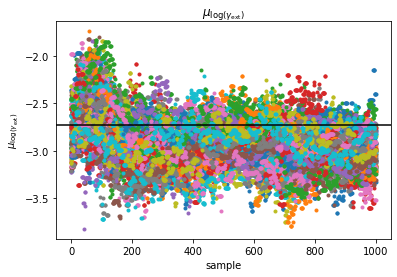

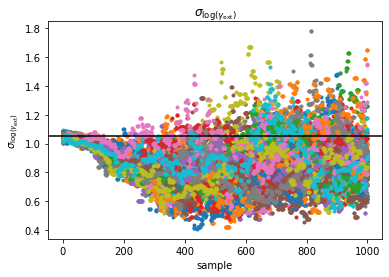

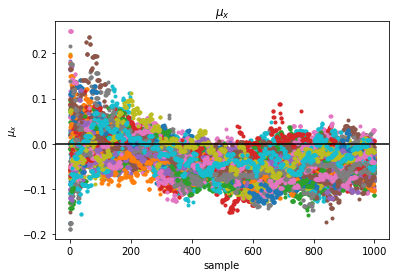

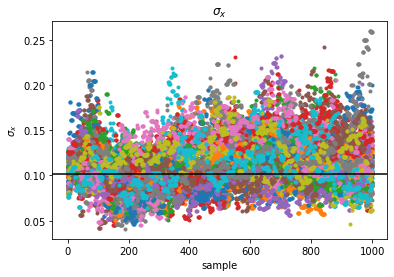

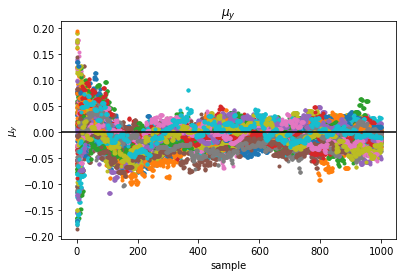

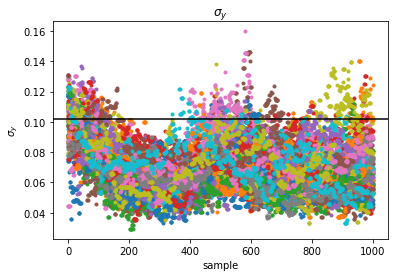

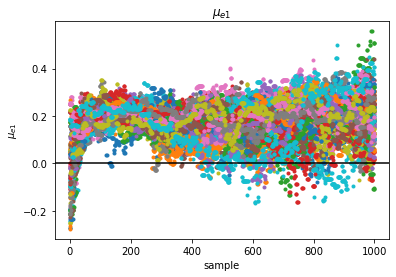

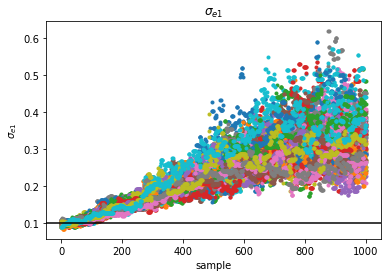

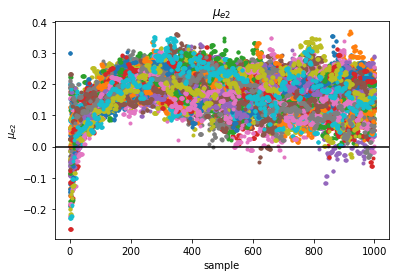

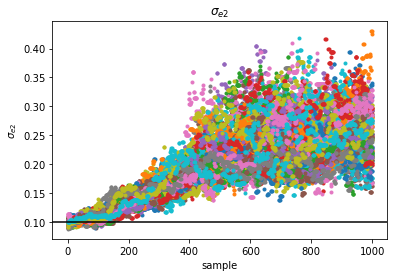

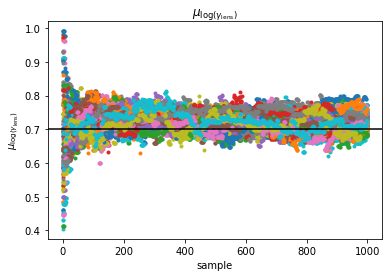

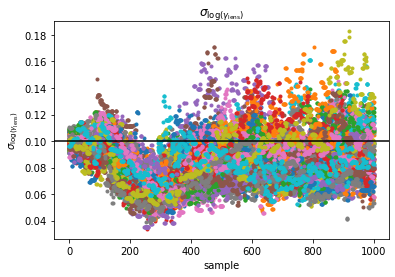

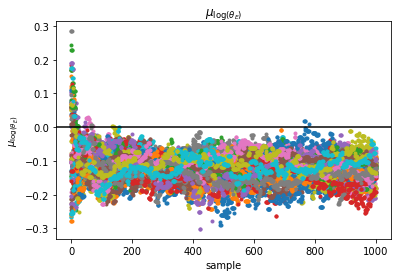

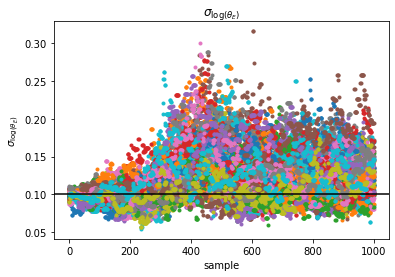

In [10]:
burnin = 0
hier_infer.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)

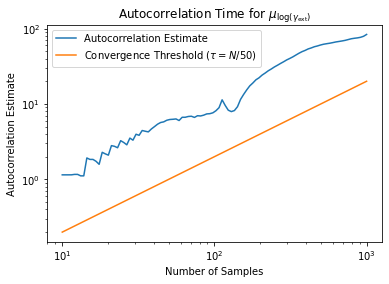

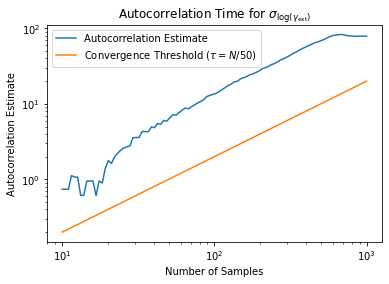

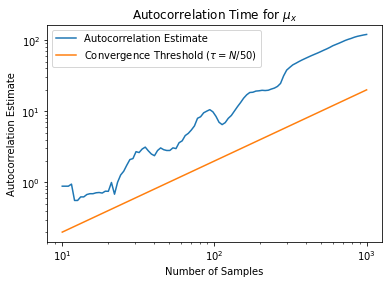

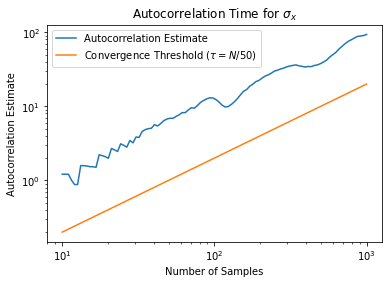

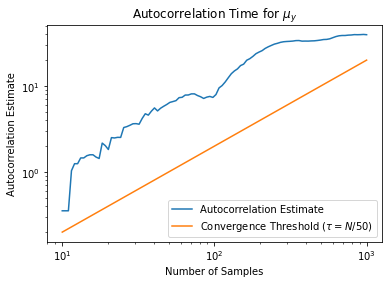

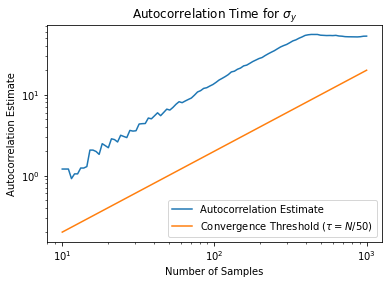

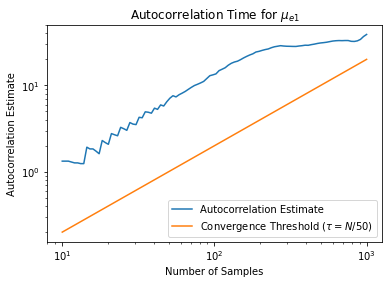

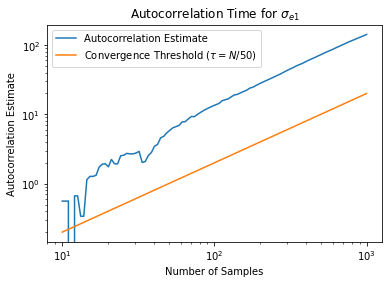

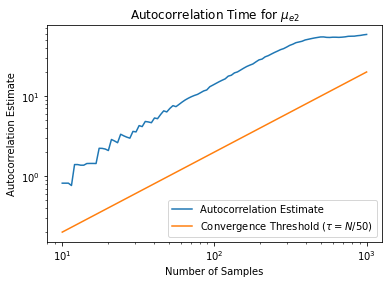

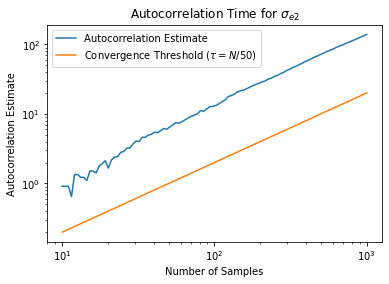

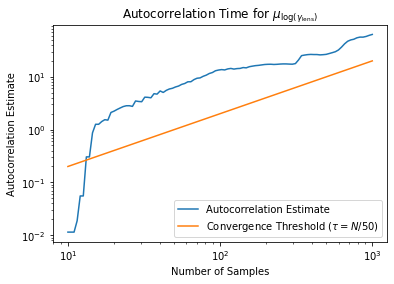

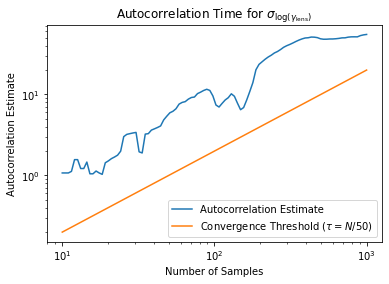

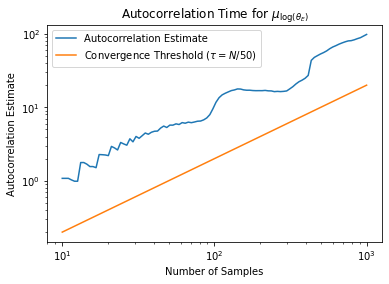

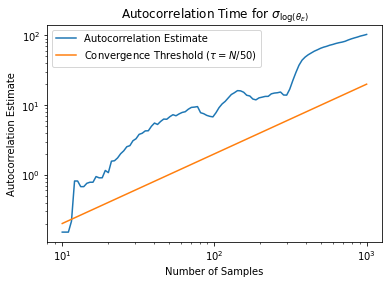

In [11]:
hier_infer.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

The class also allows us to inspect the results of the hierarchical inference and generate some nice plots. For an example check the hierarchical inference notebook in the papers folder.

In [ ]:
# Delete the weights we generated.
os.remove('demo_hier_samples.h5')
shutil.rmtree('fow_model_bnn_samps')